# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 72.6 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2024

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage.

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
taiwanese_bankruptcy, taiwanese_variables = load_data_from_ucimlrepo(572)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
taiwanese_bankruptcy.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   Realized Sales Gross Margin  Operating Profit Rate  \
0                     0.601457               0.998969   
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   Pre-tax net Interest Rate  After-tax net Interest Rate  \
0                   0.796887                     0.808809   
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   Non-industry income and expenditure/revenue  \
0                                     0.302646   
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   Continuous interest rate (after tax)  ...  Total assets to GNP price  \
0                              0.780985  ...                   0.009219   
1                              0.781506  ...                   0.008323   
2                              0.780284  ...                   0.040003   
3                              0.781241  ...                   0.003252   
4                              0.781550  ...                   0.003878   

   No-credit Interval  Gross Profit to Sales  \
0            0.622879               0.601453   
1            0.623652               0.610237   
2            0.623841               0.601449   
3            0.622929               0.583538   
4            0.623521               0.598782   

   Net Income to Stockholder's Equity  Liability to Equity  \
0                            0.827890             0.290202   
1                            0.839969             0.283846   
2                            0.836774             0.290189   
3                            0.834697             0.281721   
4                            0.839973             0.278514   

   Degree of Financial Leverage (DFL)  \
0                            0.026601   
1                            0.264577   
2                            0.026555   
3                            0.026697   
4                            0.024752   

   Interest Coverage Ratio (Interest expense to EBIT)  Net Income Flag  \
0                                           0.564050                 1   
1                                           0.570175                 1   
2                                           0.563706                 1   
3                                           0.564663                 1   
4                                           0.575617                 1   

   Equity to Liability  Target  
0             0.016469       

In [ ]:
taiwanese_variables

name     role        type  \
0                                           Bankrupt?   Target     Integer   
1   ROA(C) before interest and depreciation before...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3   ROA(B) before interest and depreciation after tax  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liability to Equity  Feature  Continuous   
92                 Degree of Financial Leverage (DFL)  Feature  Continuous   
93  Interest Coverage Ratio (Interest expense to E...  Feature  Continuous   
94                                    Net Income Flag  Feature     Integer   
95                                Equity to Liability  Feature  Continuous   

   demographic description units missing_values  
0         None        None  None             no  
1         None        None  None             no  
2         None        None  None             no  
3         None        None  None             no  
4         None        None  None             no  
..         ...         ...   ...            ...  
91        None        None  None             no  
92        None        None  None             no  
93        None        None  None             no  
94        None        None  None             no  
95        None        None  None             no  

[96 rows x 7 columns]

# **Data summary and quality**

In [ ]:
describe_data(taiwanese_bankruptcy)


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.505180         
std                                             0.060686         
min                                             0.000000         
25%                                             0.476527         
50%                                             0.502706         
75%                                             0.535563         
max                                             1.000000         

       ROA(A) before interest and % after tax  \
count                             6819.000000   
mean                                 0.

# **Split data in train and test set**

In [ ]:
taiwanese_bankruptcy_train, taiwanese_bankruptcy_test = train_test_split(
    taiwanese_bankruptcy, test_size=0.20, random_state=RANDOM_STATE,
    stratify=taiwanese_bankruptcy["Target"]
)
taiwanese_bankruptcy_train['Target'].value_counts()

Target
0    5279
1     176
Name: count, dtype: int64

In [ ]:
taiwanese_bankruptcy_test['Target'].value_counts()

Target
0    1320
1      44
Name: count, dtype: int64

# **Correlation**

In [ ]:
taiwanese_bankruptcy_train.dtypes

ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Target                                                       int64
Length: 96, dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

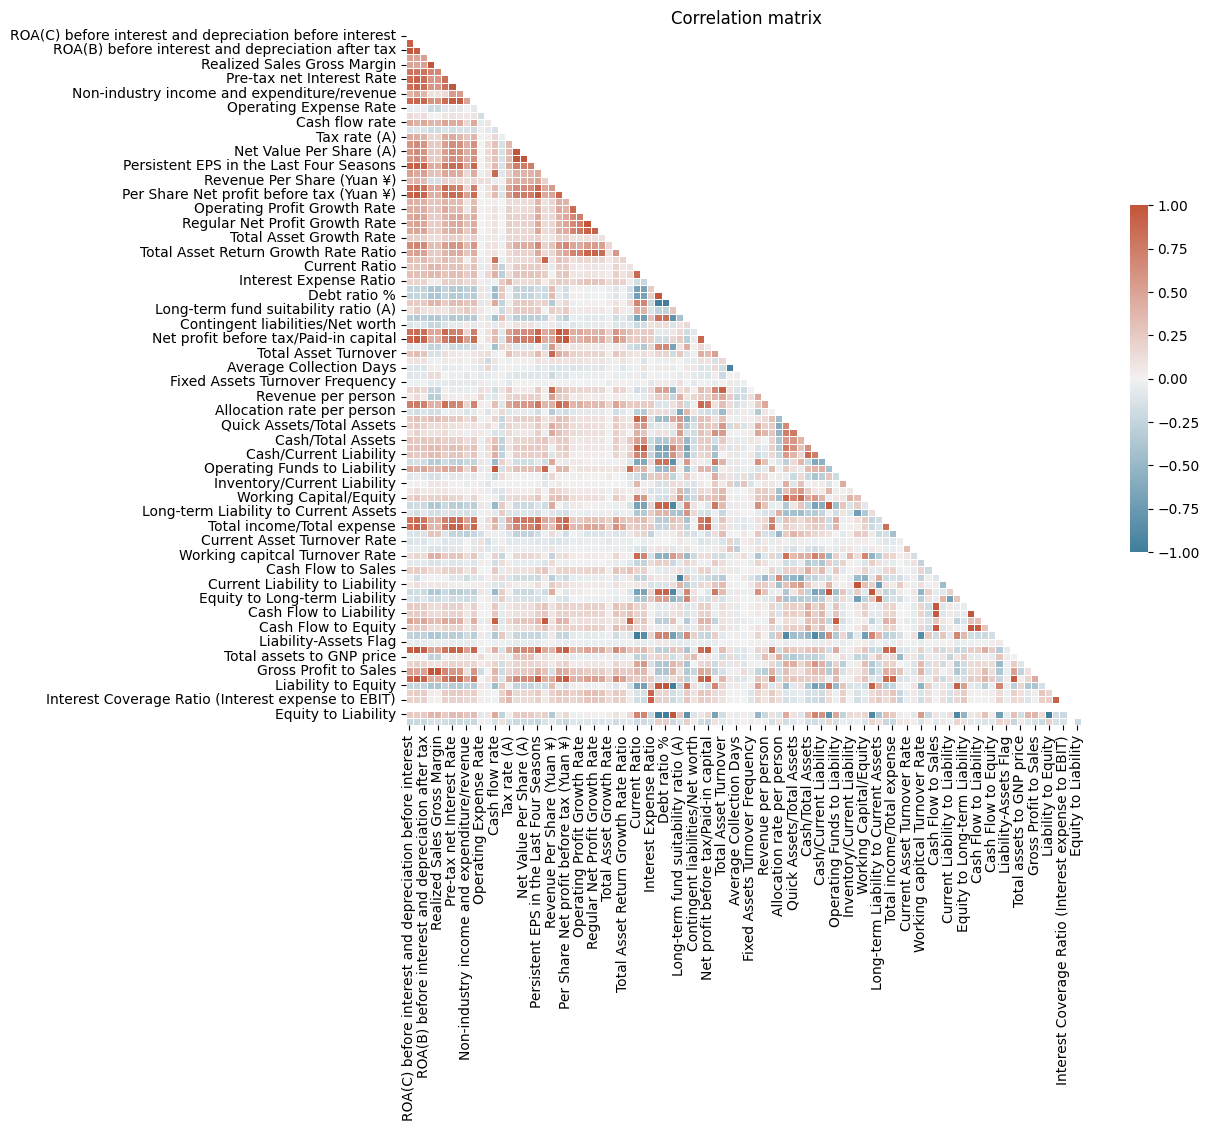

In [ ]:
taiwan_corr = calculate_correlation(taiwanese_bankruptcy_train, 'spearman')

In [ ]:
abs(taiwan_corr['Target']).sort_values(ascending=False)

Target                                      1.000000
Persistent EPS in the Last Four Seasons     0.235663
Net profit before tax/Paid-in capital       0.230565
Net Income to Total Assets                  0.230513
Per Share Net profit before tax (Yuan ¥)    0.229934
                                              ...   
Cash Turnover Rate                          0.021378
Operating Expense Rate                      0.018537
Net Worth Turnover Rate (times)             0.011220
Inventory Turnover Rate (times)             0.006542
Net Income Flag                                  NaN
Name: Target, Length: 96, dtype: float64

df columns:  Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

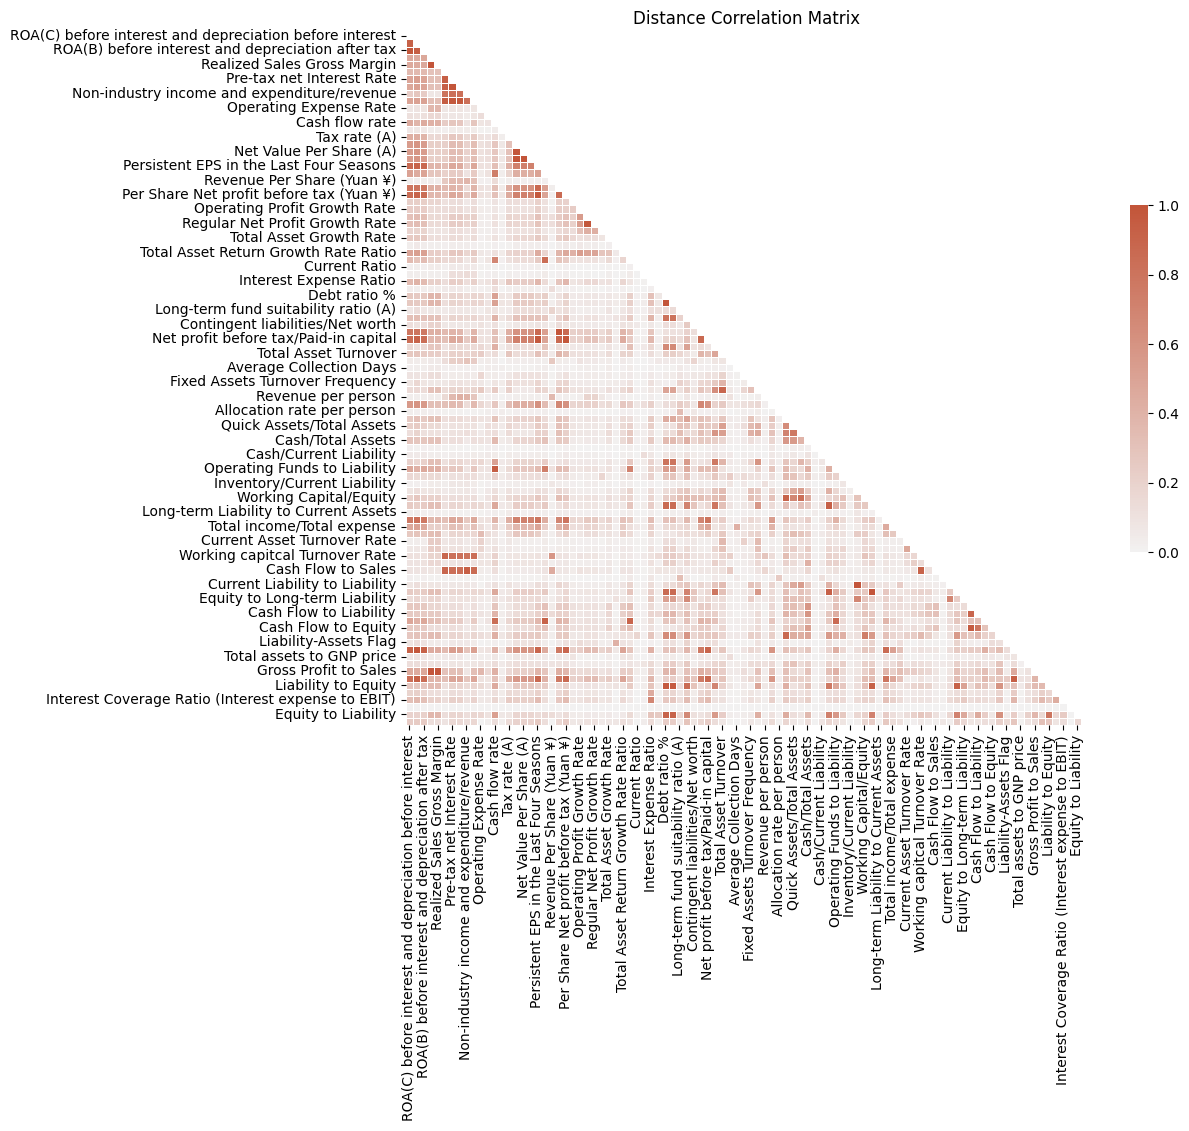

In [ ]:
taiwan_dist_corr = calculate_distance_correlation_matrix(taiwanese_bankruptcy_train)

In [ ]:
taiwan_dist_corr['Target'].sort_values(ascending=False)

Target                                1.000000
Net Income to Stockholder's Equity    0.318214
Borrowing dependency                  0.293902
Net Income to Total Assets            0.274853
Liability to Equity                   0.267842
                                        ...   
Revenue Per Share (Yuan ¥)            0.004884
Operating Expense Rate                0.003952
Quick Assets/Current Liability        0.003496
Current Ratio                         0.002472
Net Income Flag                       0.000000
Name: Target, Length: 96, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
filtered_features = filter_out_intercorrelated_features(taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
eliminated feature:  Net Income to Total Assets 0.9229225242164265
eliminated feature:  Persistent EPS in the Last Four Seasons 0.8659792670788311
eliminated feature:  ROA(A) before interest and % after tax 0.9147228865422486
eliminated feature:  ROA(B) before interest and depreciation after tax 0.8494552594400555
eliminated feature:  ROA(C) before interest and depreciation before interest 0.8358567451256378
eliminated feature:  Net profit before tax/Paid-in capital 0.8684301506246517
eliminated feature:  Per Share Net profit before tax (Yuan ¥) 0.8648115427624863
appended feature:  Borrowing dependency
eliminated feature:  Liability to Equity 0.8477243589006391
eliminated feature:  Debt ratio % 0.8091262508475018
eliminated feature:  Net worth/Assets 0.8091262508680306
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liability to Equity
eliminated feature:  Current Liabilities/Equity 1.000000000039116

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

taiwan_zero_variance_columns = identify_zero_variance_columns(taiwanese_bankruptcy_train[filtered_features])

if DROP_WEAK_FEATURES:
  taiwan_weak_features = identify_weak_associated_features(taiwan_dist_corr, "Target", WEAK_THRESHOLD)
else:
  taiwan_weak_features = []

remove_columns = set(taiwan_zero_variance_columns + taiwan_weak_features)
remove_columns = [col for col in remove_columns if col in filtered_features]
print(remove_columns)

taiwanese_bankruptcy_train = taiwanese_bankruptcy_train[filtered_features + ['Target']].drop(columns=remove_columns)
taiwanese_bankruptcy_test = taiwanese_bankruptcy_test[filtered_features + ['Target']].drop(columns=remove_columns)

Variance of each column:
Net Income to Stockholder's Equity     1.142005e-04
Borrowing dependency                   1.746485e-04
Retained Earnings to Total Assets      6.532374e-04
Current Liability to Equity            1.799902e-04
Current Liability to Current Assets    8.129577e-04
                                           ...     
Revenue Per Share (Yuan ¥)             2.924505e+15
Operating Expense Rate                 1.048444e+19
Quick Assets/Current Liability         2.640251e+16
Current Ratio                          1.386343e+15
Net Income Flag                        0.000000e+00
Length: 63, dtype: float64
Columns with zero variance to be dropped:
['Net Income Flag']
['Net Income Flag']


In [ ]:
print('Original number of features: ', len(taiwanese_bankruptcy.columns))
print('Number of features after pre-feature selection: ', len(taiwanese_bankruptcy_train.columns))

Original number of features:  96
Number of features after pre-feature selection:  63


# **Imbalanced dataset**

In [ ]:
X_train = taiwanese_bankruptcy_train.drop('Target', axis=1)
y_train = taiwanese_bankruptcy_train['Target']

X_test = taiwanese_bankruptcy_test.drop('Target', axis=1)
y_test = taiwanese_bankruptcy_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0      5279    0.967736
1.0       176    0.032264

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
taiwan_imputation_values_dict = calculate_imputation_values_for_missing(taiwanese_bankruptcy_train)
taiwan_imputation_values_dict

{"Net Income to Stockholder's Equity": 0.8411523034602,
 'Borrowing dependency': 0.37273615861037,
 'Retained Earnings to Total Assets': 0.937552052393016,
 'Current Liability to Equity': 0.329706911346658,
 'Current Liability to Current Assets': 0.0278099099572458,
 'Net Value Per Share (A)': 0.184273734777296,
 'Working Capital/Equity': 0.736004124304401,
 'Operating Profit Per Share (Yuan ¥)': 0.104063187036886,
 'Continuous interest rate (after tax)': 0.781633272898093,
 'Equity to Long-term Liability': 0.112397156141889,
 'Equity to Liability': 0.033605209578893,
 'Operating profit per person': 0.395852649193822,
 'Liability-Assets Flag': 0.0,
 'Tax rate (A)': 0.0713634983297905,
 'Interest Expense Ratio': 0.630698894535691,
 'Total income/Total expense': 0.0023344136491821,
 'Interest Coverage Ratio (Interest expense to EBIT)': 0.565253481232158,
 'Operating Gross Margin': 0.605939837703051,
 'Cash flow rate': 0.464992493059225,
 'Inventory and accounts receivable/Net value': 0.4

In [ ]:
taiwan_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
taiwan_cat_vars

['Liability-Assets Flag']

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [None],
    'min_samples_split': [0.001],
    'min_samples_leaf': [0.001]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:09:54.884317

Nested Cross-validation Results:
Individual scores: [0.2987013  0.2875     0.32214765]
Average nested CV score: 0.303 (+/- 0.029)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001}

Best Model Performance:
Best CV score: 0.303
2025-01-16 13:09:57.469073

Execution time: 0.04 minutes




```
Starting hyperparameter tuning at: 2025-01-15 16:10:03.181400

Nested Cross-validation Results:
Individual scores: [0.29333333 0.26351351 0.29411765]
Average nested CV score: 0.284 (+/- 0.028)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001}

Best Model Performance:
Best CV score: 0.303

2025-01-15 16:10:34.439806

Execution time: 0.52 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
8                Continuous interest rate (after tax)    0.377672  0.030132
45                         Total debt/Total net worth    0.291423  0.013401
43                                        Quick Ratio    0.205641  0.032087
60                     Quick Assets/Current Liability    0.152960  0.013586
44                                 Cash Turnover Rate    0.076474  0.007992
19        Inventory and accounts receivable/Net value    0.071474  0.008057
36                            Total Asset Growth Rate    0.069139  0.017189
2                   Retained Earnings to Total Assets    0.065998  0.004040
52                         Allocation rate per person    0.059610  0.006246
14                             Interest Expense Ratio    0.054938  0.007533
47                Interest-bearing debt interest rate    0.050868  0.007548
18                                     Cash flow rate    0.048024  0.010959
55                       Accounts Receivable Turnover    0.043920  0.010036
35                              Net Value Growth Rate    0.039559  0.003968
51                          Total assets to GNP price    0.032604  0.010436
30                 Degree of Financial Leverage (DFL)    0.028125  0.001897
42                                 Revenue per person    0.028039  0.005627
50                    Inventory Turnover Rate (times)    0.027944  0.003761
9                       Equity to Long-term Liability    0.026743  0.004059
39            Realized Sales Gross Profit Growth Rate    0.025889  0.004487
46              Research and development expense rate    0.025539  0.005891
28                          Inventory/Working Capital    0.025214  0.005005
21                                Cash Flow Per Share    0.023374  0.003927
58                         Revenue Per Share (Yuan ¥)    0.023034  0.005018
5                             Net Value Per Share (A)    0.021435  0.001968
56                            Average Collection Days    0.019873  0.003720
11                        Operating profit per person    0.017127  0.003876
6                              Working Capital/Equity    0.014901  0.001851
37                       Operating Profit Growth Rate    0.014102  0.005687
49                          Quick Asset Turnover Rate    0.013122  0.004875
3                         Current Liability to Equity    0.013119  0.005368
38                    Fixed Assets Turnover Frequency    0.011785  0.005886
1                                Borrowing dependency    0.011708  0.005443
32                               Total Asset Turnover    0.011291  0.005089
33                          Quick Assets/Total Assets    0.009697  0.002446
23                               Total expense/Assets    0.009476  0.005231
15                         Total income/Total expense    0.008077  0.003926
16  Interest Coverage Ratio (Interest expense to E...    0.007608  0.002374
59                             Operating Expense Rate    0.006150  0.001852
24                   After-tax Net Profit Growth Rate    0.005442  0.003593
4                 Current Liability to Current Assets    0.004534  0.003529
48                     Current Liability to Liability    0.000818  0.001888
17                             Operating Gross Margin   -0.004155  0.001433

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

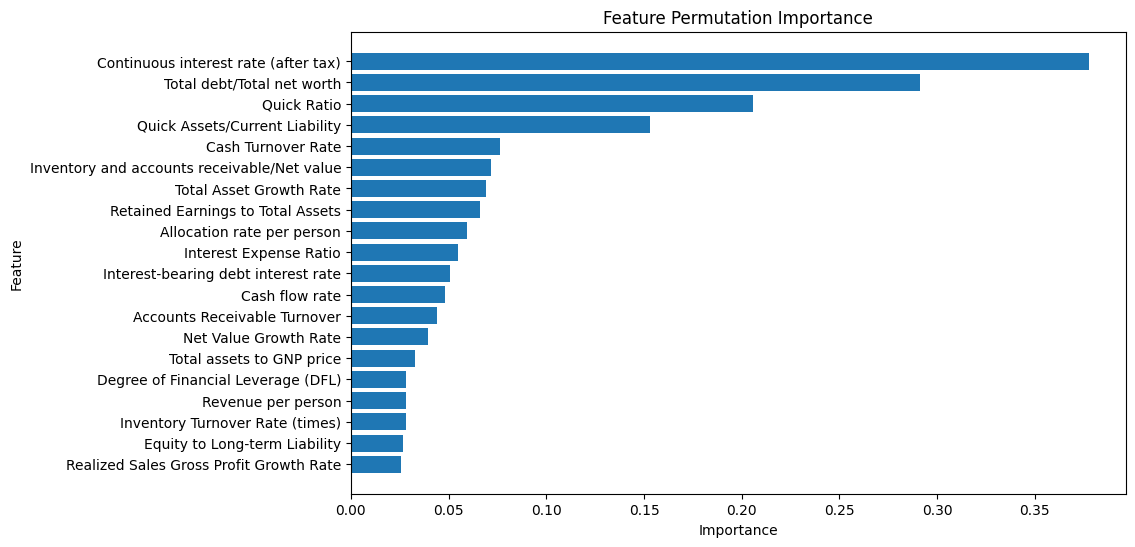

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    taiwan_imputation_values_dict, 20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Current Liability
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio', 'Quick Assets/Current Liability']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio', 'Quick Assets/Current Liability', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Invento

In [ ]:
dt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1261  59  25      24.36   43.18        95.53     93.84     31.15   
1    4  1293  27  40      12.90    9.09        97.95     95.09     10.67   
2    4  1293  27  40      12.90    9.09        97.95     95.09     10.67   
3    3  1295  25  41      10.71    6.82        98.11     95.16      8.33   
4    3  1295  25  41      10.71    6.82        98.11     95.16      8.33   
5    3  1293  27  41      10.00    6.82        97.95     95.01      8.11   
6    3  1293  27  41      10.00    6.82        97.95     95.01      8.11   
7    3  1293  27  41      10.00    6.82        97.95     95.01      8.11   
8    3  1293  27  41      10.00    6.82        97.95     95.01      8.11   
9    3  1308  12  41      20.00    6.82        99.09     96.11     10.17   
10   6  1303  17  38      26.09   13.64        98.71     95.97     17.91   
11   6  1303  17  38      26.09   13.64        98.71     95.97     17.91   
12   6  1303  17  38      26.09   13.64        98.71     95.97     17.91   
13   6  1303  17  38      26.09   13.64        98.71     95.97     17.91   
14   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
15   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
16   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
17   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
18   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
19   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
20   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   

    balanced_accuracy  num_feat_missing  \
0               69.36                 0   
1               53.52                 1   
2               53.52                 2   
3               52.46                 3   
4               52.46                 4   
5               52.39                 5   
6               52.39                 6   
7               52.39                 7   
8               52.39                 8   
9               52.95                 9   
10              56.17                10   
11              56.17                11   
12              56.17                12   
13              56.17                13   
14              56.21                14   
15              56.21                15   
16              56.21                16   
17              56.21                17   
18              56.21                18   
19              56.21                19   
20              56.21                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:09:59.236037

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital',

In [ ]:
dt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1261  59  25      24.36   43.18        95.53     93.84     31.15   
1   20  1262  58  24      25.64   45.45        95.61     93.99     32.79   
2   23  1265  55  21      29.49   52.27        95.83     94.43     37.70   
3    6  1295  25  38      19.35   13.64        98.11     95.38     16.00   
4    4  1296  24  40      14.29    9.09        98.18     95.31     11.11   
5    4  1300  20  40      16.67    9.09        98.48     95.60     11.76   
6    4  1300  20  40      16.67    9.09        98.48     95.60     11.76   
7    4  1298  22  40      15.38    9.09        98.33     95.45     11.43   
8    6  1299  21  38      22.22   13.64        98.41     95.67     16.90   
9    7  1299  21  37      25.00   15.91        98.41     95.75     19.44   
10   7  1302  18  37      28.00   15.91        98.64     95.97     20.29   
11   7  1303  17  37      29.17   15.91        98.71     96.04     20.59   
12   7  1303  17  37      29.17   15.91        98.71     96.04     20.59   
13   7  1306  14  37      33.33   15.91        98.94     96.26     21.54   
14   6  1306  14  38      30.00   13.64        98.94     96.19     18.75   
15   6  1305  15  38      28.57   13.64        98.86     96.11     18.46   
16   6  1305  15  38      28.57   13.64        98.86     96.11     18.46   
17   6  1304  16  38      27.27   13.64        98.79     96.04     18.18   
18   2  1308  12  42      14.29    4.55        99.09     96.04      6.90   
19   2  1304  16  42      11.11    4.55        98.79     95.75      6.45   
20   2  1303  17  42      10.53    4.55        98.71     95.67      6.35   

    balanced_accuracy  num_feat_missing  \
0               69.36                 0   
1               70.53                 1   
2               74.05                 2   
3               55.87                 3   
4               53.64                 4   
5               53.79                 5   
6               53.79                 6   
7               53.71                 7   
8               56.02                 8   
9               57.16                 9   
10              57.27                10   
11              57.31                11   
12              57.31                12   
13              57.42                13   
14              56.29                14   
15              56.25                15   
16              56.25                16   
17              56.21                17   
18              51.82                18   
19              51.67                19   
20              51.63                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [100],
      'max_features': ['sqrt'],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.001],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:15:12.160780

Nested Cross-validation Results:
Individual scores: [0.4496124  0.50769231 0.40875912]
Average nested CV score: 0.455 (+/- 0.081)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.455
2025-01-16 13:15:19.179745

Execution time: 0.12 minutes




```
Starting hyperparameter tuning at: 2025-01-16 00:59:22.320527

Nested Cross-validation Results:
Individual scores: [0.44571429 0.42639594 0.38      ]
Average nested CV score: 0.417 (+/- 0.055)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.455
2025-01-16 02:04:18.619011

Execution time: 64.94 minutes
```



In [ ]:
# rf_grid_search.cv_results_

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
52                   Allocation rate per person    0.018152  0.003606
55                 Accounts Receivable Turnover    0.014014  0.002436
28                    Inventory/Working Capital    0.012800  0.000971
19  Inventory and accounts receivable/Net value    0.009332  0.002614
49                    Quick Asset Turnover Rate    0.008998  0.004661
..                                          ...         ...       ...
2             Retained Earnings to Total Assets   -0.030390  0.005090
10                          Equity to Liability   -0.035249  0.009011
15                   Total income/Total expense   -0.037623  0.011071
45                   Total debt/Total net worth   -0.045393  0.004930
8          Continuous interest rate (after tax)   -0.057950  0.008800

[61 rows x 3 columns]

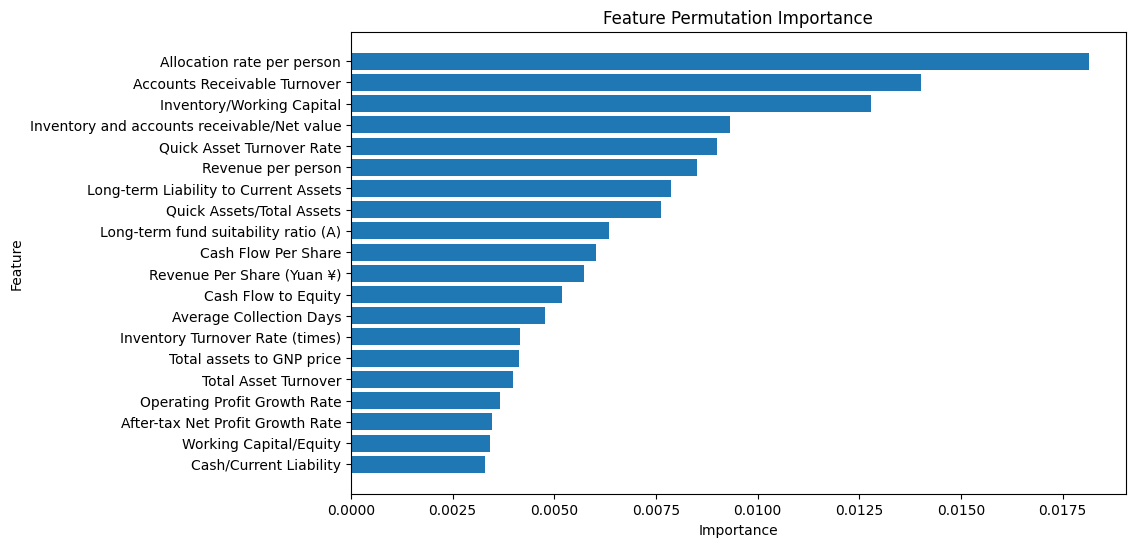

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Inventory/Working Capital
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover', 'Inventory/Working Capital']

--- NEW ITERATION ---
Removing feature:  Inventory and accounts receivable/Net value
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover', 'Inventory/Working Capital', 'Inventory and accounts receivable/Net value']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover', 'Inventory/Working Capital', 'Inventory and accounts receivable/Net value', 'Quick Asset Turnov

In [ ]:
rf_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
1   27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
2   27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
3   27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
4   27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
5   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
6   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
7   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
8   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
9   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
10  28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
11  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
12  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
13  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
14  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
15  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
16  28  1267  53  16      34.57   63.64        95.98     94.94     44.80   
17  28  1267  53  16      34.57   63.64        95.98     94.94     44.80   
18  28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
19  28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
20  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   

    balanced_accuracy  num_feat_missing  \
0               78.79                 0   
1               78.79                 1   
2               78.83                 2   
3               78.83                 3   
4               78.83                 4   
5               79.89                 5   
6               79.89                 6   
7               79.89                 7   
8               79.89                 8   
9               79.89                 9   
10              79.92                10   
11              79.89                11   
12              79.89                12   
13              79.89                13   
14              79.89                14   
15              79.89                15   
16              79.81                16   
17              79.81                17   
18              79.85                18   
19              79.85                19   
20              79.89                20   

                                              imputed  
0                                                      
1              ['Allocation rate per person'] imputed  
2   ['Allocation rate per person', 'Accounts Recei...  
3   ['Allocation rate per person', 'Accounts Recei...  
4   ['Allocation rate per person', 'Accounts Recei...  
5   ['Allocation rate per person', 'Accounts Recei...  
6   ['Allocation rate per person', 'Accounts Recei...  
7   ['Allocation rate per person', 'Accounts Recei...  
8   ['Allocation rate per person', 'Accounts Recei...  
9   ['Allocation rate per person', 'Accounts Recei...  
10  ['Allocation rate per person', 'Accounts Recei...  
11  ['Allocation rate per person', 'Accounts Recei...  
12  ['Allocation rate per person', 'Accounts Recei...  
13  ['Allocation rate per person', 'Accounts Recei...  
14  ['Allocation rate per person', 'Accounts Recei...  
15  ['Allocation rate per person', 'Accounts Recei...  
16  ['Allocation rate per person', 'Accounts Recei...  
17  ['Allocation rate per person', 'Accounts Recei...  
18  ['Allocation rate per person', 'Accounts Recei...  
19  ['Allocation rate per person', 'Accounts Recei...  
20  ['Allocation rate per person', 'Accounts Recei...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:15:23.532988

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Continge

In [ ]:
rf_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
1   27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
2   27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
3   27  1273  47  17      36.49   61.36        96.44     95.31     45.76   
4   27  1272  48  17      36.00   61.36        96.36     95.23     45.38   
5   28  1272  48  16      36.84   63.64        96.36     95.31     46.67   
6   28  1271  49  16      36.36   63.64        96.29     95.23     46.28   
7   28  1272  48  16      36.84   63.64        96.36     95.31     46.67   
8   28  1271  49  16      36.36   63.64        96.29     95.23     46.28   
9   28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
10  28  1271  49  16      36.36   63.64        96.29     95.23     46.28   
11  28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
12  28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
13  28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
14  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
15  28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
16  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
17  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
18  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
19  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
20  28  1270  50  16      35.90   63.64        96.21     95.16     45.90   

    balanced_accuracy  num_feat_missing  \
0               78.79                 0   
1               78.79                 1   
2               78.83                 2   
3               78.90                 3   
4               78.86                 4   
5               80.00                 5   
6               79.96                 6   
7               80.00                 7   
8               79.96                 8   
9               79.92                 9   
10              79.96                10   
11              79.92                11   
12              79.92                12   
13              79.92                13   
14              79.89                14   
15              79.92                15   
16              79.89                16   
17              79.89                17   
18              79.89                18   
19              79.89                19   
20              79.92                20   

                                              imputed  
0                                                      
1              ['Allocation rate per person'] imputed  
2   ['Allocation rate per person', 'Accounts Recei...  
3   ['Allocation rate per person', 'Accounts Recei...  
4   ['Allocation rate per person', 'Accounts Recei...  
5   ['Allocation rate per person', 'Accounts Recei...  
6   ['Allocation rate per person', 'Accounts Recei...  
7   ['Allocation rate per person', 'Accounts Recei...  
8   ['Allocation rate per person', 'Accounts Recei...  
9   ['Allocation rate per person', 'Accounts Recei...  
10  ['Allocation rate per person', 'Accounts Recei...  
11  ['Allocation rate per person', 'Accounts Recei...  
12  ['Allocation rate per person', 'Accounts Recei...  
13  ['Allocation rate per person', 'Accounts Recei...  
14  ['Allocation rate per person', 'Accounts Recei...  
15  ['Allocation rate per person', 'Accounts Recei...  
16  ['Allocation rate per person', 'Accounts Recei...  
17  ['Allocation rate per person', 'Accounts Recei...  
18  ['Allocation rate per person', 'Accounts Recei...  
19  ['Allocation rate per person', 'Accounts Recei...  
20  ['Allocation rate per person', 'Accounts Recei...

##**Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

29.994318181818183

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'min_child_samples': [15],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:20:40.525890

Nested Cross-validation Results:
Individual scores: [0.45454545 0.53225806 0.52307692]
Average nested CV score: 0.503 (+/- 0.069)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.503
2025-01-16 13:20:44.546053

Execution time: 0.07 minutes



```
Starting hyperparameter tuning at: 2025-01-13 02:30:42.108451

Nested Cross-validation Results:
Individual scores: [0.49275362 0.44927536 0.44594595]
Average nested CV score: 0.463 (+/- 0.043)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.0, 'n_estimators': 200, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.489

2025-01-13 02:38:19.417749

Execution time: 7.62 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 16:10:34.462476

Nested Cross-validation Results:
Individual scores: [0.5        0.48275862 0.44897959]
Average nested CV score: 0.477 (+/- 0.042)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.503

2025-01-15 16:17:59.843722

Execution time: 7.42 minutes
```



In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
47                Interest-bearing debt interest rate    0.078984  0.004845
42                                 Revenue per person    0.049810  0.004475
2                   Retained Earnings to Total Assets    0.044790  0.016004
46              Research and development expense rate    0.043120  0.006680
45                         Total debt/Total net worth    0.040866  0.007742
38                    Fixed Assets Turnover Frequency    0.037293  0.008962
49                          Quick Asset Turnover Rate    0.031990  0.003993
55                       Accounts Receivable Turnover    0.029371  0.006367
58                         Revenue Per Share (Yuan ¥)    0.023071  0.003166
50                    Inventory Turnover Rate (times)    0.021071  0.001882
34                             Fixed Assets to Assets    0.019493  0.008130
22                                  Cash/Total Assets    0.015498  0.003597
51                          Total assets to GNP price    0.015493  0.004242
17                             Operating Gross Margin    0.014972  0.005434
48                     Current Liability to Liability    0.013979  0.002045
36                            Total Asset Growth Rate    0.013089  0.005863
6                              Working Capital/Equity    0.012956  0.002287
44                                 Cash Turnover Rate    0.012443  0.002514
30                 Degree of Financial Leverage (DFL)    0.011936  0.001256
24                   After-tax Net Profit Growth Rate    0.011423  0.001256
11                        Operating profit per person    0.011412  0.003465
23                               Total expense/Assets    0.010905  0.002511
29                   Contingent liabilities/Net worth    0.010902  0.003006
27                                Cash Flow to Equity    0.010852  0.007499
26                             Cash/Current Liability    0.010392  0.002300
41               Long-term fund suitability ratio (A)    0.008850  0.001263
56                            Average Collection Days    0.008839  0.003484
52                         Allocation rate per person    0.006958  0.003804
21                                Cash Flow Per Share    0.006768  0.003889
5                             Net Value Per Share (A)    0.005884  0.007582
33                          Quick Assets/Total Assets    0.005224  0.001644
59                             Operating Expense Rate    0.005216  0.003288
18                                     Cash flow rate    0.005190  0.005906
4                 Current Liability to Current Assets    0.004706  0.001043
19        Inventory and accounts receivable/Net value    0.004703  0.001946
14                             Interest Expense Ratio    0.003663  0.001277
7                 Operating Profit Per Share (Yuan ¥)    0.003652  0.003547
31                             Cash Flow to Liability    0.003388  0.006887
60                     Quick Assets/Current Liability    0.003142  0.001043
37                       Operating Profit Growth Rate    0.003142  0.001043
10                                Equity to Liability    0.002621  0.000000
9                       Equity to Long-term Liability    0.002618  0.001653
39            Realized Sales Gross Profit Growth Rate    0.002618  0.001653
57                        Inventory/Current Liability    0.002618  0.001653
32                               Total Asset Turnover    0.002096  0.001048
16  Interest Coverage Ratio (Interest expense to E...    0.002094  0.001956
25                                 No-credit Interval    0.001569  0.002091
54                        Current Asset Turnover Rate   -0.000003  0.001662
20               Total Asset Return Growth Rate Ratio   -0.000006  0.002350
28                          Inventory/Working Capital   -0.001581  0.001291
0                  Net Income to Stockholder's Equity   -0.002635  0.000000
40                  Continuous Net Profit Growth Rate   -0.002649  0.003737
1                 

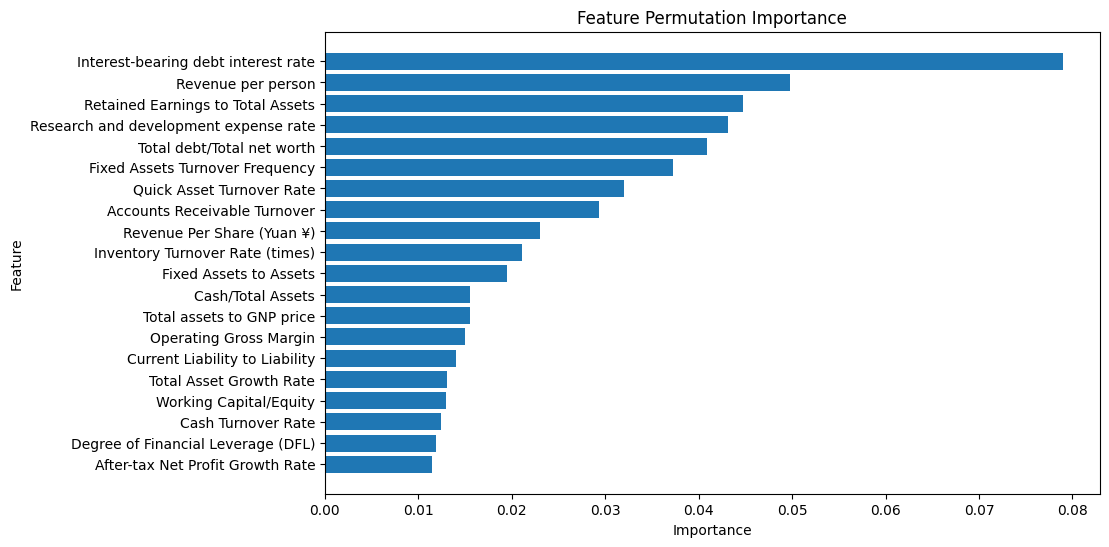

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Research and development expense rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Retained Earnings to Total Assets', 'Research and development expense rate']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Retained Earnings to Total Assets', 'Research and development expense rate', 

In [ ]:
gbt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1295  25  21      47.92   52.27        98.11     96.63     50.00   
1   20  1303  17  24      54.05   45.45        98.71     96.99     49.38   
2   19  1299  21  25      47.50   43.18        98.41     96.63     45.24   
3    2  1317   3  42      40.00    4.55        99.77     96.70      8.16   
4    4  1315   5  40      44.44    9.09        99.62     96.70     15.09   
5    1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
6    1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
7    1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
8    1  1319   1  43      50.00    2.27        99.92     96.77      4.35   
9    1  1319   1  43      50.00    2.27        99.92     96.77      4.35   
10   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
11   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
12   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
13   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
14   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
15   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               75.19                 0   
1               72.08                 1   
2               70.80                 2   
3               52.16                 3   
4               54.36                 4   
5               51.06                 5   
6               51.06                 6   
7               51.06                 7   
8               51.10                 8   
9               51.10                 9   
10              49.96                10   
11              49.96                11   
12              49.96                12   
13              49.96                13   
14              49.96                14   
15              49.96                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:20:48.546274

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 

In [ ]:
gbt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1295  25  21      47.92   52.27        98.11     96.63     50.00   
1   26  1288  32  18      44.83   59.09        97.58     96.33     50.98   
2   26  1284  36  18      41.94   59.09        97.27     96.04     49.06   
3   26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
4   27  1269  51  17      34.62   61.36        96.14     95.01     44.26   
5   26  1262  58  18      30.95   59.09        95.61     94.43     40.62   
6   27  1262  58  17      31.76   61.36        95.61     94.50     41.86   
7   27  1254  66  17      29.03   61.36        95.00     93.91     39.42   
8   26  1268  52  18      33.33   59.09        96.06     94.87     42.62   
9   24  1262  58  20      29.27   54.55        95.61     94.28     38.10   
10  26  1262  58  18      30.95   59.09        95.61     94.43     40.62   
11  25  1265  55  19      31.25   56.82        95.83     94.57     40.32   
12  25  1269  51  19      32.89   56.82        96.14     94.87     41.67   
13  26  1267  53  18      32.91   59.09        95.98     94.79     42.28   
14  27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
15  26  1268  52  18      33.33   59.09        96.06     94.87     42.62   
16  28  1259  61  16      31.46   63.64        95.38     94.35     42.11   
17  28  1261  59  16      32.18   63.64        95.53     94.50     42.75   
18  26  1257  63  18      29.21   59.09        95.23     94.06     39.10   
19  27  1256  64  17      29.67   61.36        95.15     94.06     40.00   
20  28  1256  64  16      30.43   63.64        95.15     94.13     41.18   

    balanced_accuracy  num_feat_missing  \
0               75.19                 0   
1               78.33                 1   
2               78.18                 2   
3               78.14                 3   
4               78.75                 4   
5               77.35                 5   
6               78.48                 6   
7               78.18                 7   
8               77.58                 8   
9               75.08                 9   
10              77.35                10   
11              76.33                11   
12              76.48                12   
13              77.54                13   
14              78.71                14   
15              77.58                15   
16              79.51                16   
17              79.58                17   
18              77.16                18   
19              78.26                19   
20              79.39                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10, 5, 1, 0.5, 0],           # L2 regularization on weights
      'gamma': [1, 0.5, 0.1, 0.05, 0.0],         # Minimum loss reduction required for tree splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [5],
      'reg_lambda':[5.0],
      'gamma': [0.5],
      'colsample_bytree':[1.0]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:26:03.373207

Nested Cross-validation Results:
Individual scores: [0.44247788 0.51376147 0.54545455]
Average nested CV score: 0.501 (+/- 0.086)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.501
2025-01-16 13:26:07.092379

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-13 01:49:33.193290

Nested Cross-validation Results:
Individual scores: [0.275      0.39506173 0.44186047]
Average nested CV score: 0.371 (+/- 0.141)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.448

2025-01-13 02:09:56.878399

Execution time: 20.39 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 16:17:59.862940

Nested Cross-validation Results:
Individual scores: [0.44230769 0.45       0.49180328]
Average nested CV score: 0.461 (+/- 0.043)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 5}

Best Model Performance:
Best CV score: 0.501

2025-01-15 16:37:20.620349

Execution time: 19.35 minutes
```



In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
43                              Quick Ratio    0.024998  0.007478
52               Allocation rate per person    0.018434  0.001423
46    Research and development expense rate    0.014006  0.000000
47      Interest-bearing debt interest rate    0.013509  0.004484
42                       Revenue per person    0.011781  0.003232
49                Quick Asset Turnover Rate    0.009565  0.001364
45               Total debt/Total net worth    0.009008  0.004480
31                   Cash Flow to Liability    0.006770  0.001372
51                Total assets to GNP price    0.006770  0.001372
36                  Total Asset Growth Rate    0.005077  0.003283
44                       Cash Turnover Rate    0.004529  0.002265
48           Current Liability to Liability    0.003960  0.001380
29         Contingent liabilities/Net worth    0.003396  0.001127
57              Inventory/Current Liability    0.002826  0.002527
40        Continuous Net Profit Growth Rate    0.002826  0.002527
38          Fixed Assets Turnover Frequency    0.002823  0.003086
23                     Total expense/Assets    0.002266  0.001133
18                           Cash flow rate    0.002263  0.002115
1                      Borrowing dependency    0.002263  0.002115
58               Revenue Per Share (Yuan ¥)    0.002263  0.002115
26                   Cash/Current Liability    0.001700  0.001388
5                   Net Value Per Share (A)    0.001700  0.001388
59                   Operating Expense Rate    0.001700  0.001388
22                        Cash/Total Assets    0.001133  0.001388
55             Accounts Receivable Turnover    0.001133  0.001388
56                  Average Collection Days    0.001133  0.001388
33                Quick Assets/Total Assets    0.001133  0.001388
8      Continuous interest rate (after tax)    0.000567  0.001133
30       Degree of Financial Leverage (DFL)    0.000567  0.001133
27                      Cash Flow to Equity    0.000567  0.001133
39  Realized Sales Gross Profit Growth Rate    0.000567  0.001133
2         Retained Earnings to Total Assets    0.000567  0.001133
35                    Net Value Growth Rate    0.000567  0.001133

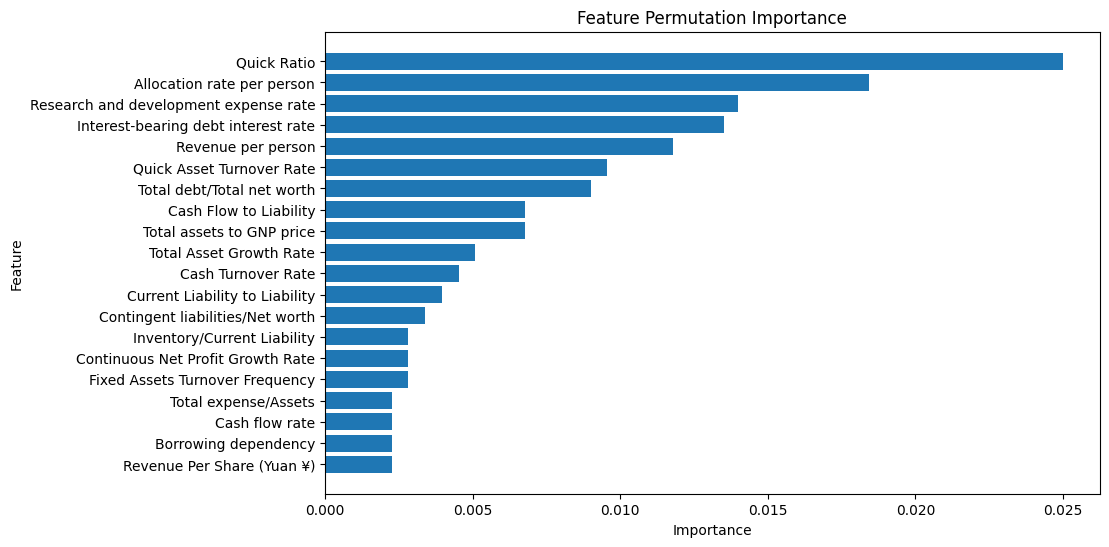

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Quick Ratio', 'Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Research and development expense rate
Original feat removed so far:  ['Quick Ratio', 'Allocation rate per person', 'Research and development expense rate']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Quick Ratio', 'Allocation rate per person', 'Research and development expense rate', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Quick Ratio', 'Allocation rate per person', 'Research and development expense rate', 'Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original fea

In [ ]:
xgb_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   21  1298  22  23      48.84   47.73        98.33     96.70     48.28   
1    7  1312   8  37      46.67   15.91        99.39     96.70     23.73   
2    7  1314   6  37      53.85   15.91        99.55     96.85     24.56   
3    9  1311   9  35      50.00   20.45        99.32     96.77     29.03   
4    7  1314   6  37      53.85   15.91        99.55     96.85     24.56   
5    7  1313   7  37      50.00   15.91        99.47     96.77     24.14   
6    7  1312   8  37      46.67   15.91        99.39     96.70     23.73   
7    2  1316   4  42      33.33    4.55        99.70     96.63      8.00   
8    2  1317   3  42      40.00    4.55        99.77     96.70      8.16   
9    1  1317   3  43      25.00    2.27        99.77     96.63      4.17   
10   1  1317   3  43      25.00    2.27        99.77     96.63      4.17   
11   1  1317   3  43      25.00    2.27        99.77     96.63      4.17   
12   1  1317   3  43      25.00    2.27        99.77     96.63      4.17   
13   1  1317   3  43      25.00    2.27        99.77     96.63      4.17   
14   1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
15   1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
16   0  1318   2  44       0.00    0.00        99.85     96.63      0.00   
17   0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               73.03                 0   
1               57.65                 1   
2               57.73                 2   
3               59.89                 3   
4               57.73                 4   
5               57.69                 5   
6               57.65                 6   
7               52.12                 7   
8               52.16                 8   
9               51.02                 9   
10              51.02                10   
11              51.02                11   
12              51.02                12   
13              51.02                13   
14              51.06                14   
15              51.06                15   
16              49.92                16   
17              49.96                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                             ['Quick Ratio'] imputed  
2   ['Quick Ratio', 'Allocation rate per person'] ...  
3   ['Quick Ratio', 'Allocation rate per person', ...  
4   ['Quick Ratio', 'Allocation rate per person', ...  
5   ['Quick Ratio', 'Allocation rate per person', ...  
6   ['Quick Ratio', 'Allocation rate per person', ...  
7   ['Quick Ratio', 'Allocation rate per person', ...  
8   ['Quick Ratio', 'Allocation rate per person', ...  
9   ['Quick Ratio', 'Allocation rate per person', ...  
10  ['Quick Ratio', 'Allocation rate per person', ...  
11  ['Quick Ratio', 'Allocation rate per person', ...  
12  ['Quick Ratio', 'Allocation rate per person', ...  
13  ['Quick Ratio', 'Allocation rate per person', ...  
14  ['Quick Ratio', 'Allocation rate per person', ...  
15  ['Quick Ratio', 'Allocation rate per person', ...  
16  ['Quick Ratio', 'Allocation rate per person', ...  
17  ['Quick Ratio', 'Allocation rate per person', ...  
18  ['Quick Ratio', 'Allocation rate per person', ...  
19  ['Quick Ratio', 'Allocation rate per person', ...  
20  ['Quick Ratio', 'Allocation rate per person', ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:26:09.943813

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent liabilities/

In [ ]:
xgb_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   21  1298  22  23      48.84   47.73        98.33     96.70     48.28   
1   12  1311   9  32      57.14   27.27        99.32     96.99     36.92   
2   12  1312   8  32      60.00   27.27        99.39     97.07     37.50   
3   12  1310  10  32      54.55   27.27        99.24     96.92     36.36   
4   10  1307  13  34      43.48   22.73        99.02     96.55     29.85   
5   12  1305  15  32      44.44   27.27        98.86     96.55     33.80   
6   13  1304  16  31      44.83   29.55        98.79     96.55     35.62   
7   12  1303  17  32      41.38   27.27        98.71     96.41     32.88   
8   14  1303  17  30      45.16   31.82        98.71     96.55     37.33   
9   14  1302  18  30      43.75   31.82        98.64     96.48     36.84   
10  15  1299  21  29      41.67   34.09        98.41     96.33     37.50   
11  11  1298  22  33      33.33   25.00        98.33     95.97     28.57   
12  13  1299  21  31      38.24   29.55        98.41     96.19     33.33   
13  12  1300  20  32      37.50   27.27        98.48     96.19     31.58   
14  13  1297  23  31      36.11   29.55        98.26     96.04     32.50   
15  12  1300  20  32      37.50   27.27        98.48     96.19     31.58   
16  14  1296  24  30      36.84   31.82        98.18     96.04     34.15   
17  14  1296  24  30      36.84   31.82        98.18     96.04     34.15   
18  13  1296  24  31      35.14   29.55        98.18     95.97     32.10   
19  14  1300  20  30      41.18   31.82        98.48     96.33     35.90   
20  14  1298  22  30      38.89   31.82        98.33     96.19     35.00   

    balanced_accuracy  num_feat_missing  \
0               73.03                 0   
1               63.30                 1   
2               63.33                 2   
3               63.26                 3   
4               60.87                 4   
5               63.07                 5   
6               64.17                 6   
7               62.99                 7   
8               65.27                 8   
9               65.23                 9   
10              66.25                10   
11              61.67                11   
12              63.98                12   
13              62.88                13   
14              63.90                14   
15              62.88                15   
16              65.00                16   
17              65.00                17   
18              63.86                18   
19              65.15                19   
20              65.08                20   

                                              imputed  
0                                                      
1                             ['Quick Ratio'] imputed  
2   ['Quick Ratio', 'Allocation rate per person'] ...  
3   ['Quick Ratio', 'Allocation rate per person', ...  
4   ['Quick Ratio', 'Allocation rate per person', ...  
5   ['Quick Ratio', 'Allocation rate per person', ...  
6   ['Quick Ratio', 'Allocation rate per person', ...  
7   ['Quick Ratio', 'Allocation rate per person', ...  
8   ['Quick Ratio', 'Allocation rate per person', ...  
9   ['Quick Ratio', 'Allocation rate per person', ...  
10  ['Quick Ratio', 'Allocation rate per person', ...  
11  ['Quick Ratio', 'Allocation rate per person', ...  
12  ['Quick Ratio', 'Allocation rate per person', ...  
13  ['Quick Ratio', 'Allocation rate per person', ...  
14  ['Quick Ratio', 'Allocation rate per person', ...  
15  ['Quick Ratio', 'Allocation rate per person', ...  
16  ['Quick Ratio', 'Allocation rate per person', ...  
17  ['Quick Ratio', 'Allocation rate per person', ...  
18  ['Quick Ratio', 'Allocation rate per person', ...  
19  ['Quick Ratio', 'Allocation rate per person', ...  
20  ['Quick Ratio', 'Allocation rate per person', ...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [200],
      'max_depth': [None],
      'max_features':['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:31:23.445330

Nested Cross-validation Results:
Individual scores: [0.46153846 0.49152542 0.42962963]
Average nested CV score: 0.461 (+/- 0.051)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.461
2025-01-16 13:31:28.916566

Execution time: 0.09 minutes




```
Starting hyperparameter tuning at: 2025-01-15 16:37:20.628821

Nested Cross-validation Results:
Individual scores: [0.42424242 0.46979866 0.42647059]
Average nested CV score: 0.440 (+/- 0.042)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.461

2025-01-15 16:57:36.068421

Execution time: 20.26 minutes
```



In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
50  Inventory Turnover Rate (times)    0.011317  0.001535
44               Cash Turnover Rate    0.010922  0.006232
49        Quick Asset Turnover Rate    0.009506  0.001133
48   Current Liability to Liability    0.009496  0.002931
38  Fixed Assets Turnover Frequency    0.009102  0.007736
..                              ...         ...       ...
15       Total income/Total expense   -0.030125  0.006402
22                Cash/Total Assets   -0.030431  0.006910
13                     Tax rate (A)   -0.037196  0.006756
10              Equity to Liability   -0.048378  0.006229
1              Borrowing dependency   -0.065638  0.002947

[62 rows x 3 columns]

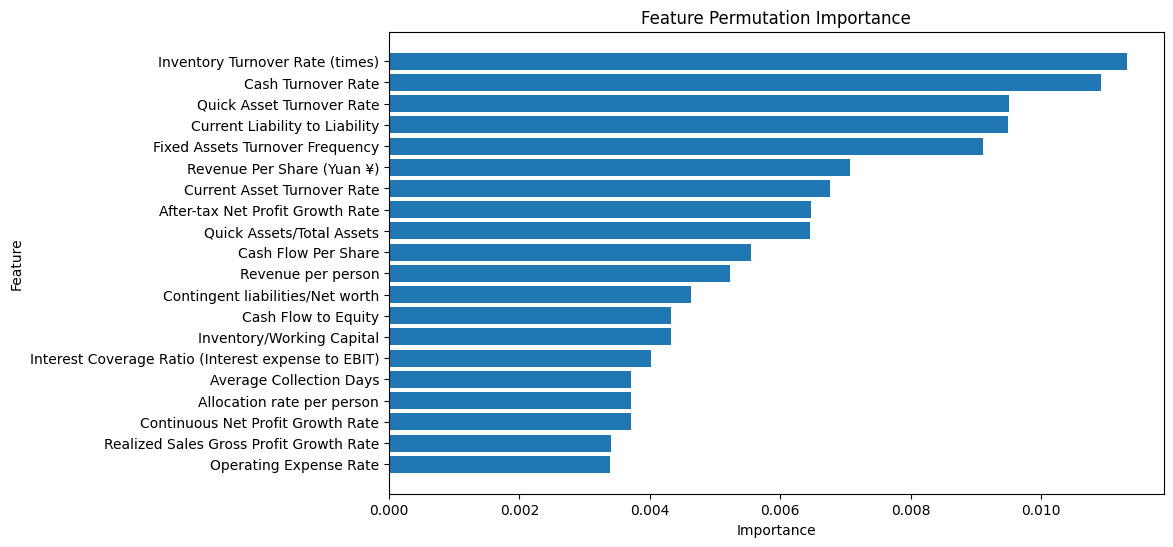

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Cash Turnover Rate', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Current Liability to Liability
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Cash Turnover Rate', 'Quick Asset Turnover Rate', 'Current Liability to Liability']

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Cash Turnover Rate', 'Quick Asset Turnover Rate', 'Current Liability to Liability', 'Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing featu

In [ ]:
et_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   26  1275  45  18      36.62   59.09        96.59     95.38     45.22   
1   26  1276  44  18      37.14   59.09        96.67     95.45     45.61   
2   26  1272  48  18      35.14   59.09        96.36     95.16     44.07   
3   26  1271  49  18      34.67   59.09        96.29     95.09     43.70   
4   27  1269  51  17      34.62   61.36        96.14     95.01     44.26   
5   26  1271  49  18      34.67   59.09        96.29     95.09     43.70   
6   26  1272  48  18      35.14   59.09        96.36     95.16     44.07   
7   27  1272  48  17      36.00   61.36        96.36     95.23     45.38   
8   27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
9   28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
10  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
11  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
12  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
13  27  1269  51  17      34.62   61.36        96.14     95.01     44.26   
14  27  1269  51  17      34.62   61.36        96.14     95.01     44.26   
15  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
16  27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
17  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
18  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
19  26  1271  49  18      34.67   59.09        96.29     95.09     43.70   
20  27  1270  50  17      35.06   61.36        96.21     95.09     44.63   

    balanced_accuracy  num_feat_missing  \
0               77.84                 0   
1               77.88                 1   
2               77.73                 2   
3               77.69                 3   
4               78.75                 4   
5               77.69                 5   
6               77.73                 6   
7               78.86                 7   
8               78.83                 8   
9               79.92                 9   
10              78.83                10   
11              78.83                11   
12              78.83                12   
13              78.75                13   
14              78.75                14   
15              78.83                15   
16              78.79                16   
17              78.83                17   
18              78.83                18   
19              77.69                19   
20              78.79                20   

                                              imputed  
0                                                      
1         ['Inventory Turnover Rate (times)'] imputed  
2   ['Inventory Turnover Rate (times)', 'Cash Turn...  
3   ['Inventory Turnover Rate (times)', 'Cash Turn...  
4   ['Inventory Turnover Rate (times)', 'Cash Turn...  
5   ['Inventory Turnover Rate (times)', 'Cash Turn...  
6   ['Inventory Turnover Rate (times)', 'Cash Turn...  
7   ['Inventory Turnover Rate (times)', 'Cash Turn...  
8   ['Inventory Turnover Rate (times)', 'Cash Turn...  
9   ['Inventory Turnover Rate (times)', 'Cash Turn...  
10  ['Inventory Turnover Rate (times)', 'Cash Turn...  
11  ['Inventory Turnover Rate (times)', 'Cash Turn...  
12  ['Inventory Turnover Rate (times)', 'Cash Turn...  
13  ['Inventory Turnover Rate (times)', 'Cash Turn...  
14  ['Inventory Turnover Rate (times)', 'Cash Turn...  
15  ['Inventory Turnover Rate (times)', 'Cash Turn...  
16  ['Inventory Turnover Rate (times)', 'Cash Turn...  
17  ['Inventory Turnover Rate (times)', 'Cash Turn...  
18  ['Inventory Turnover Rate (times)', 'Cash Turn...  
19  ['Inventory Turnover Rate (times)', 'Cash Turn...  
20  ['Inventory Turnover Rate (times)', 'Cash Turn...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:31:36.778029

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Con

In [ ]:
et_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   26  1275  45  18      36.62   59.09        96.59     95.38     45.22   
1   26  1276  44  18      37.14   59.09        96.67     95.45     45.61   
2   26  1273  47  18      35.62   59.09        96.44     95.23     44.44   
3   26  1277  43  18      37.68   59.09        96.74     95.53     46.02   
4   27  1275  45  17      37.50   61.36        96.59     95.45     46.55   
5   27  1274  46  17      36.99   61.36        96.52     95.38     46.15   
6   27  1273  47  17      36.49   61.36        96.44     95.31     45.76   
7   27  1273  47  17      36.49   61.36        96.44     95.31     45.76   
8   27  1274  46  17      36.99   61.36        96.52     95.38     46.15   
9   24  1274  46  20      34.29   54.55        96.52     95.16     42.11   
10  23  1273  47  21      32.86   52.27        96.44     95.01     40.35   
11  26  1273  47  18      35.62   59.09        96.44     95.23     44.44   
12  27  1272  48  17      36.00   61.36        96.36     95.23     45.38   
13  27  1272  48  17      36.00   61.36        96.36     95.23     45.38   
14  27  1272  48  17      36.00   61.36        96.36     95.23     45.38   
15  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   
16  27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
17  26  1276  44  18      37.14   59.09        96.67     95.45     45.61   
18  25  1273  47  19      34.72   56.82        96.44     95.16     43.10   
19  26  1274  46  18      36.11   59.09        96.52     95.31     44.83   
20  27  1274  46  17      36.99   61.36        96.52     95.38     46.15   

    balanced_accuracy  num_feat_missing  \
0               77.84                 0   
1               77.88                 1   
2               77.77                 2   
3               77.92                 3   
4               78.98                 4   
5               78.94                 5   
6               78.90                 6   
7               78.90                 7   
8               78.94                 8   
9               75.53                 9   
10              74.36                10   
11              77.77                11   
12              78.86                12   
13              78.86                13   
14              78.86                14   
15              78.83                15   
16              78.79                16   
17              77.88                17   
18              76.63                18   
19              77.80                19   
20              78.94                20   

                                              imputed  
0                                                      
1         ['Inventory Turnover Rate (times)'] imputed  
2   ['Inventory Turnover Rate (times)', 'Cash Turn...  
3   ['Inventory Turnover Rate (times)', 'Cash Turn...  
4   ['Inventory Turnover Rate (times)', 'Cash Turn...  
5   ['Inventory Turnover Rate (times)', 'Cash Turn...  
6   ['Inventory Turnover Rate (times)', 'Cash Turn...  
7   ['Inventory Turnover Rate (times)', 'Cash Turn...  
8   ['Inventory Turnover Rate (times)', 'Cash Turn...  
9   ['Inventory Turnover Rate (times)', 'Cash Turn...  
10  ['Inventory Turnover Rate (times)', 'Cash Turn...  
11  ['Inventory Turnover Rate (times)', 'Cash Turn...  
12  ['Inventory Turnover Rate (times)', 'Cash Turn...  
13  ['Inventory Turnover Rate (times)', 'Cash Turn...  
14  ['Inventory Turnover Rate (times)', 'Cash Turn...  
15  ['Inventory Turnover Rate (times)', 'Cash Turn...  
16  ['Inventory Turnover Rate (times)', 'Cash Turn...  
17  ['Inventory Turnover Rate (times)', 'Cash Turn...  
18  ['Inventory Turnover Rate (times)', 'Cash Turn...  
19  ['Inventory Turnover Rate (times)', 'Cash Turn...  
20  ['Inventory Turnover Rate (times)', 'Cash Turn...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, taiwan_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = taiwan_scaler)

In [ ]:
taiwan_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [5.0],
    'kernel': ['poly'],
    'gamma': [1.0],
    'degree': [3]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:36:51.362296

Nested Cross-validation Results:
Individual scores: [0.30337079 0.2375     0.32258065]
Average nested CV score: 0.288 (+/- 0.073)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.288
2025-01-16 13:36:58.919582

Execution time: 0.13 minutes




```
Starting hyperparameter tuning at: 2025-01-15 16:57:36.108077

Nested Cross-validation Results:
Individual scores: [0.28125    0.21126761 0.27966102]
Average nested CV score: 0.257 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 5, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.288

2025-01-15 17:03:48.514502

Execution time: 6.21 minutes
```



In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
32                               Total Asset Turnover    0.326376  0.014217
33                          Quick Assets/Total Assets    0.248281  0.011501
10                                Equity to Liability    0.216796  0.015433
49                          Quick Asset Turnover Rate    0.210597  0.007880
38                    Fixed Assets Turnover Frequency    0.149552  0.005016
44                                 Cash Turnover Rate    0.147065  0.012109
48                     Current Liability to Liability    0.145536  0.013476
46              Research and development expense rate    0.109958  0.013971
22                                  Cash/Total Assets    0.108601  0.009144
36                            Total Asset Growth Rate    0.105607  0.018867
50                    Inventory Turnover Rate (times)    0.099438  0.011481
13                                       Tax rate (A)    0.083591  0.005248
59                             Operating Expense Rate    0.072665  0.005991
54                        Current Asset Turnover Rate    0.071014  0.003672
4                 Current Liability to Current Assets    0.032631  0.001988
23                               Total expense/Assets    0.032549  0.003834
11                        Operating profit per person    0.032391  0.007997
31                             Cash Flow to Liability    0.030412  0.004806
3                         Current Liability to Equity    0.027449  0.001267
2                   Retained Earnings to Total Assets    0.024795  0.005989
1                                Borrowing dependency    0.020661  0.010291
27                                Cash Flow to Equity    0.019554  0.004499
12                              Liability-Assets Flag    0.016253  0.000914
5                             Net Value Per Share (A)    0.014575  0.006122
57                        Inventory/Current Liability    0.012161  0.003429
24                   After-tax Net Profit Growth Rate    0.011381  0.002177
26                             Cash/Current Liability    0.011343  0.003818
55                       Accounts Receivable Turnover    0.010285  0.001417
45                         Total debt/Total net worth    0.008526  0.001340
16  Interest Coverage Ratio (Interest expense to E...    0.007189  0.002333
39            Realized Sales Gross Profit Growth Rate    0.007142  0.001633
17                             Operating Gross Margin    0.006197  0.005193
53              Long-term Liability to Current Assets    0.005739  0.006638
37                       Operating Profit Growth Rate    0.005122  0.001178
51                          Total assets to GNP price    0.004796  0.001116
30                 Degree of Financial Leverage (DFL)    0.004496  0.002811
25                                 No-credit Interval    0.003933  0.001196
28                          Inventory/Working Capital    0.003734  0.000869
34                             Fixed Assets to Assets    0.003429  0.000468
43                                        Quick Ratio    0.003335  0.001219
47                Interest-bearing debt interest rate    0.002976  0.002713
42                                 Revenue per person    0.002961  0.000573
14                             Interest Expense Ratio    0.002795  0.002611
41               Long-term fund suitability ratio (A)    0.001960  0.003216
29                   Contingent liabilities/Net worth    0.001170  0.001046
6                              Working Capital/Equity    0.000691  0.002820
56                            Average Collection Days    0.000264  0.000528
8                Continuous interest rate (after tax)    0.000234  0.000878
0                  Net Income to Stockholder's Equity   -0.000534  0.003411
15                         Total income/Total expense   -0.001177  0.000745
9                       Equity to Long-term Liability   -0.001891  0.002189
19        Inventory and accounts receivable/Net value   -0.003690  0.002568
18                

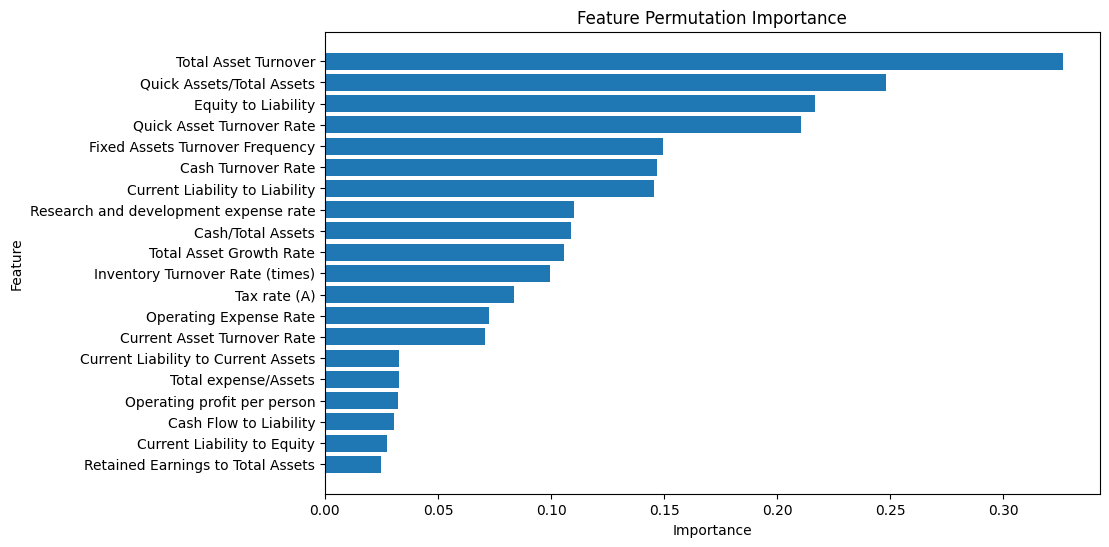

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability', 'Quick Asset Turnover Rate', 'Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Total Asset T

In [ ]:
svm_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1252   68  22      24.44   50.00        94.85     93.40     32.84   
1   13  1218  102  31      11.30   29.55        92.27     90.25     16.35   
2   23  1179  141  21      14.02   52.27        89.32     88.12     22.12   
3   21  1197  123  23      14.58   47.73        90.68     89.30     22.34   
4   14  1232   88  30      13.73   31.82        93.33     91.35     19.18   
5   13  1239   81  31      13.83   29.55        93.86     91.79     18.84   
6   15  1200  120  29      11.11   34.09        90.91     89.08     16.76   
7   18  1138  182  26       9.00   40.91        86.21     84.75     14.75   
8   16  1123  197  28       7.51   36.36        85.08     83.50     12.45   
9   15  1129  191  29       7.28   34.09        85.53     83.87     12.00   
10  14  1075  245  30       5.41   31.82        81.44     79.84      9.24   
11  14  1029  291  30       4.59   31.82        77.95     76.47      8.02   
12  14  1045  275  30       4.84   31.82        79.17     77.64      8.41   
13  14  1112  208  30       6.31   31.82        84.24     82.55     10.53   
14  14  1100  220  30       5.98   31.82        83.33     81.67     10.07   
15  23  1095  225  21       9.27   52.27        82.95     81.96     15.75   
16  23  1112  208  21       9.96   52.27        84.24     83.21     16.73   
17  23  1111  209  21       9.91   52.27        84.17     83.14     16.67   
18  25  1125  195  19      11.36   56.82        85.23     84.31     18.94   
19  32  1089  231  12      12.17   72.73        82.50     82.18     20.85   
20  33  1056  264  11      11.11   75.00        80.00     79.84     19.35   

    balanced_accuracy  num_feat_missing  \
0               72.42                 0   
1               60.91                 1   
2               70.80                 2   
3               69.20                 3   
4               62.58                 4   
5               61.70                 5   
6               62.50                 6   
7               63.56                 7   
8               60.72                 8   
9               59.81                 9   
10              56.63                10   
11              54.89                11   
12              55.49                12   
13              58.03                13   
14              57.58                14   
15              67.61                15   
16              68.26                16   
17              68.22                17   
18              71.02                18   
19              77.61                19   
20              77.50                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Quick Assets/Total A...  
3   ['Total Asset Turnover', 'Quick Assets/Total A...  
4   ['Total Asset Turnover', 'Quick Assets/Total A...  
5   ['Total Asset Turnover', 'Quick Assets/Total A...  
6   ['Total Asset Turnover', 'Quick Assets/Total A...  
7   ['Total Asset Turnover', 'Quick Assets/Total A...  
8   ['Total Asset Turnover', 'Quick Assets/Total A...  
9   ['Total Asset Turnover', 'Quick Assets/Total A...  
10  ['Total Asset Turnover', 'Quick Assets/Total A...  
11  ['Total Asset Turnover', 'Quick Assets/Total A...  
12  ['Total Asset Turnover', 'Quick Assets/Total A...  
13  ['Total Asset Turnover', 'Quick Assets/Total A...  
14  ['Total Asset Turnover', 'Quick Assets/Total A...  
15  ['Total Asset Turnover', 'Quick Assets/Total A...  
16  ['Total Asset Turnover', 'Quick Assets/Total A...  
17  ['Total Asset Turnover', 'Quick Assets/Total A...  
18  ['Total Asset Turnover', 'Quick Assets/Total A...  
19  ['Total Asset Turnover', 'Quick Assets/Total A...  
20  ['Total Asset Turnover', 'Quick Assets/Total A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:37:12.450731

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent lia

In [ ]:
svm_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1252   68  22      24.44   50.00        94.85     93.40     32.84   
1   19  1258   62  25      23.46   43.18        95.30     93.62     30.40   
2   21  1257   63  23      25.00   47.73        95.23     93.70     32.81   
3   19  1264   56  25      25.33   43.18        95.76     94.06     31.93   
4   21  1190  130  23      13.91   47.73        90.15     88.78     21.54   
5   24  1170  150  20      13.79   54.55        88.64     87.54     22.02   
6   25  1157  163  19      13.30   56.82        87.65     86.66     21.55   
7   27  1130  190  17      12.44   61.36        85.61     84.82     20.69   
8   24  1117  203  20      10.57   54.55        84.62     83.65     17.71   
9   24  1132  188  20      11.32   54.55        85.76     84.75     18.75   
10  26  1057  263  18       9.00   59.09        80.08     79.40     15.62   
11  28  1083  237  16      10.57   63.64        82.05     81.45     18.12   
12  25  1130  190  19      11.63   56.82        85.61     84.68     19.31   
13  27  1097  223  17      10.80   61.36        83.11     82.40     18.37   
14  36  1059  261   8      12.12   81.82        80.23     80.28     21.11   
15  37  1050  270   7      12.05   84.09        79.55     79.69     21.08   
16  36  1047  273   8      11.65   81.82        79.32     79.40     20.40   
17  37  1054  266   7      12.21   84.09        79.85     79.99     21.33   
18  37  1047  273   7      11.94   84.09        79.32     79.47     20.90   
19  37  1027  293   7      11.21   84.09        77.80     78.01     19.79   
20  37  1040  280   7      11.67   84.09        78.79     78.96     20.50   

    balanced_accuracy  num_feat_missing  \
0               72.42                 0   
1               69.24                 1   
2               71.48                 2   
3               69.47                 3   
4               68.94                 4   
5               71.59                 5   
6               72.23                 6   
7               73.48                 7   
8               69.58                 8   
9               70.15                 9   
10              69.58                10   
11              72.84                11   
12              71.21                12   
13              72.23                13   
14              81.02                14   
15              81.82                15   
16              80.57                16   
17              81.97                17   
18              81.70                18   
19              80.95                19   
20              81.44                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Quick Assets/Total A...  
3   ['Total Asset Turnover', 'Quick Assets/Total A...  
4   ['Total Asset Turnover', 'Quick Assets/Total A...  
5   ['Total Asset Turnover', 'Quick Assets/Total A...  
6   ['Total Asset Turnover', 'Quick Assets/Total A...  
7   ['Total Asset Turnover', 'Quick Assets/Total A...  
8   ['Total Asset Turnover', 'Quick Assets/Total A...  
9   ['Total Asset Turnover', 'Quick Assets/Total A...  
10  ['Total Asset Turnover', 'Quick Assets/Total A...  
11  ['Total Asset Turnover', 'Quick Assets/Total A...  
12  ['Total Asset Turnover', 'Quick Assets/Total A...  
13  ['Total Asset Turnover', 'Quick Assets/Total A...  
14  ['Total Asset Turnover', 'Quick Assets/Total A...  
15  ['Total Asset Turnover', 'Quick Assets/Total A...  
16  ['Total Asset Turnover', 'Quick Assets/Total A...  
17  ['Total Asset Turnover', 'Quick Assets/Total A...  
18  ['Total Asset Turnover', 'Quick Assets/Total A...  
19  ['Total Asset Turnover', 'Quick Assets/Total A...  
20  ['Total Asset Turnover', 'Quick Assets/Total A...

##**Logistic Regression**

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_taiwan_dist_corr = taiwan_dist_corr[present_features]
filtered_taiwan_dist_corr = filtered_taiwan_dist_corr[filtered_taiwan_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
appended feature:  Borrowing dependency
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liability to Equity
appended feature:  Current Liability to Current Assets
appended feature:  Net Value Per Share (A)
appended feature:  Working Capital/Equity
appended feature:  Operating Profit Per Share (Yuan ¥)
appended feature:  Continuous interest rate (after tax)
appended feature:  Equity to Long-term Liability
appended feature:  Equity to Liability
appended feature:  Operating profit per person
appended feature:  Liability-Assets Flag
appended feature:  Tax rate (A)
appended feature:  Interest Expense Ratio
appended feature:  Total income/Total expense
appended feature:  Interest Coverage Ratio (Interest expense to EBIT)
appended feature:  Operating Gross Margin
appended feature:  Cash flow rate
appended feature:  Inventory and accounts receivable/Net value
appended feature:  Total Asset Return Growth Rate 

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]

In [ ]:
print('Nr. features for Logistic Regression: ', len(lr_X_train.columns))

Nr. features for Logistic Regression:  62


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5.0],
      'penalty': ['l1'],
      'solver': ['saga']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:41:39.071768

Nested Cross-validation Results:
Individual scores: [0.36363636 0.18656716 0.25994695]
Average nested CV score: 0.270 (+/- 0.145)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.270
2025-01-16 13:41:41.052601

Execution time: 0.03 minutes




```
Starting hyperparameter tuning at: 2025-01-15 17:03:49.235828

Nested Cross-validation Results:
Individual scores: [0.24309392 0.28143713 0.26911315]
Average nested CV score: 0.265 (+/- 0.032)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.270

2025-01-15 17:06:20.371650

Execution time: 2.52 minutes
```



In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
33                          Quick Assets/Total Assets    0.022067  0.003935
22                                  Cash/Total Assets    0.021616  0.007317
23                               Total expense/Assets    0.015060  0.002612
32                               Total Asset Turnover    0.012573  0.004381
44                                 Cash Turnover Rate    0.011031  0.003203
48                     Current Liability to Liability    0.008632  0.003187
50                    Inventory Turnover Rate (times)    0.007313  0.000918
10                                Equity to Liability    0.005359  0.003142
27                                Cash Flow to Equity    0.004760  0.001012
12                              Liability-Assets Flag    0.003986  0.000163
49                          Quick Asset Turnover Rate    0.003595  0.004838
11                        Operating profit per person    0.003212  0.001888
39            Realized Sales Gross Profit Growth Rate    0.002875  0.000288
31                             Cash Flow to Liability    0.002848  0.000737
17                             Operating Gross Margin    0.002429  0.001298
19        Inventory and accounts receivable/Net value    0.002059  0.001203
0                  Net Income to Stockholder's Equity    0.002054  0.001258
45                         Total debt/Total net worth    0.002016  0.000239
46              Research and development expense rate    0.001756  0.003107
54                        Current Asset Turnover Rate    0.001688  0.000568
38                    Fixed Assets Turnover Frequency    0.001591  0.001877
36                            Total Asset Growth Rate    0.001523  0.000655
26                             Cash/Current Liability    0.001483  0.000524
25                                 No-credit Interval    0.001358  0.000696
41               Long-term fund suitability ratio (A)    0.001237  0.000290
55                       Accounts Receivable Turnover    0.000949  0.000670
47                Interest-bearing debt interest rate    0.000890  0.002984
6                              Working Capital/Equity    0.000703  0.000101
24                   After-tax Net Profit Growth Rate    0.000620  0.000000
51                          Total assets to GNP price    0.000616  0.000520
53              Long-term Liability to Current Assets    0.000580  0.000894
16  Interest Coverage Ratio (Interest expense to E...    0.000496  0.000336
9                       Equity to Long-term Liability    0.000481  0.000826
21                                Cash Flow Per Share    0.000472  0.002210
3                         Current Liability to Equity    0.000453  0.001284
1                                Borrowing dependency    0.000347  0.001211
56                            Average Collection Days    0.000331  0.000101
43                                        Quick Ratio    0.000207  0.000131
4                 Current Liability to Current Assets    0.000197  0.003536
28                          Inventory/Working Capital    0.000166  0.000155
20               Total Asset Return Growth Rate Ratio    0.000124  0.000101
37                       Operating Profit Growth Rate    0.000124  0.000310
14                             Interest Expense Ratio    0.000041  0.000083
34                             Fixed Assets to Assets    0.000041  0.000083
8                Continuous interest rate (after tax)    0.000041  0.000155
52                         Allocation rate per person    0.000041  0.000203
61                                      Current Ratio   -0.000041  0.000083
58                         Revenue Per Share (Yuan ¥)   -0.000041  0.000083
42                                 Revenue per person   -0.000080  0.000683
57                        Inventory/Current Liability   -0.000122  0.000495
2                   Retained Earnings to Total Assets   -0.000217  0.002991
30                 Degree of Financial Leverage (DFL)   -0.000249  0.000357
18                

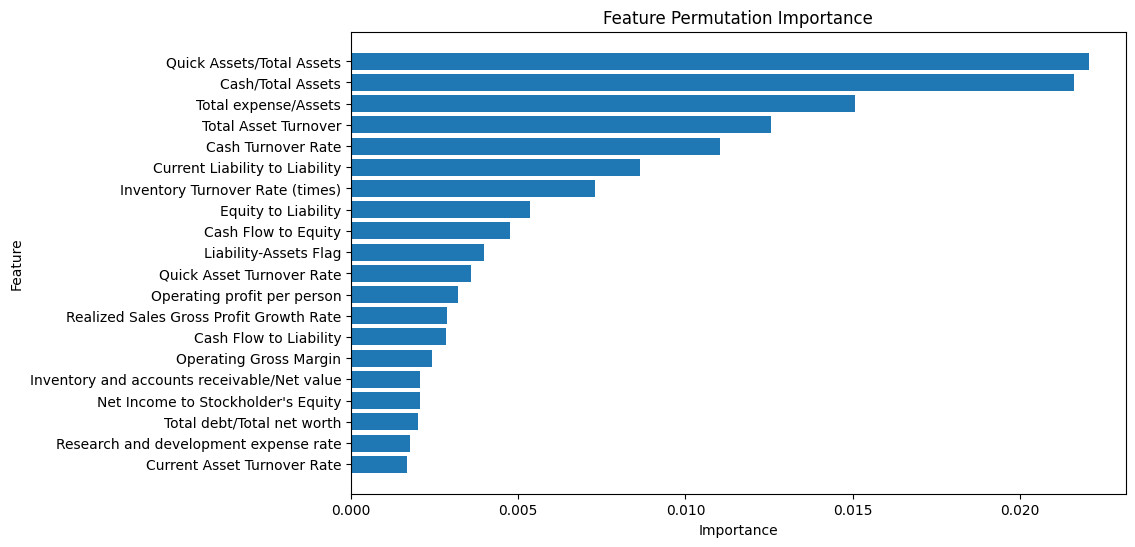

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets', 'Total expense/Assets', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets', 'Total expense/Assets', 'Total Asset Turnover', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Current Liability to Liability
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets',

In [ ]:
lr_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  1095  225   6      14.45   86.36        82.95     83.06     24.76   
1   38  1077  243   6      13.52   86.36        81.59     81.74     23.38   
2   37  1089  231   7      13.81   84.09        82.50     82.55     23.72   
3   39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
4   39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.66                 0   
1               83.98                 1   
2               83.30                 2   
3               85.91                 3   
4               85.91                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1               ['Quick Assets/Total Assets'] imputed  
2   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
3   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
4   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
5   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
6   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
7   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
8   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
9   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
10  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
11  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
12  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
13  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
14  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
15  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
16  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
17  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
18  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
19  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
20  ['Quick Assets/Total Assets', 'Cash/Total Asse...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:41:42.650860

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingen

In [ ]:
lr_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  1095  225   6      14.45   86.36        82.95     83.06     24.76   
1   38  1094  226   6      14.39   86.36        82.88     82.99     24.68   
2   39  1110  210   5      15.66   88.64        84.09     84.24     26.62   
3   39  1104  216   5      15.29   88.64        83.64     83.80     26.09   
4   41  1117  203   3      16.80   93.18        84.62     84.90     28.47   
5   37  1104  216   7      14.62   84.09        83.64     83.65     24.92   
6   39  1109  211   5      15.60   88.64        84.02     84.16     26.53   
7   39  1115  205   5      15.98   88.64        84.47     84.60     27.08   
8   39  1116  204   5      16.05   88.64        84.55     84.68     27.18   
9   39  1111  209   5      15.73   88.64        84.17     84.31     26.71   
10  38  1111  209   6      15.38   86.36        84.17     84.24     26.12   
11  37  1121  199   7      15.68   84.09        84.92     84.90     26.43   
12  37  1120  200   7      15.61   84.09        84.85     84.82     26.33   
13  37  1120  200   7      15.61   84.09        84.85     84.82     26.33   
14  37  1113  207   7      15.16   84.09        84.32     84.31     25.69   
15  37  1119  201   7      15.55   84.09        84.77     84.75     26.24   
16  37  1115  205   7      15.29   84.09        84.47     84.46     25.87   
17  37  1117  203   7      15.42   84.09        84.62     84.60     26.06   
18  37  1118  202   7      15.48   84.09        84.70     84.68     26.15   
19  36  1122  198   8      15.38   81.82        85.00     84.90     25.90   
20  38  1106  214   6      15.08   86.36        83.79     83.87     25.68   

    balanced_accuracy  num_feat_missing  \
0               84.66                 0   
1               84.62                 1   
2               86.36                 2   
3               86.14                 3   
4               88.90                 4   
5               83.86                 5   
6               86.33                 6   
7               86.55                 7   
8               86.59                 8   
9               86.40                 9   
10              85.27                10   
11              84.51                11   
12              84.47                12   
13              84.47                13   
14              84.20                14   
15              84.43                15   
16              84.28                16   
17              84.36                17   
18              84.39                18   
19              83.41                19   
20              85.08                20   

                                              imputed  
0                                                      
1               ['Quick Assets/Total Assets'] imputed  
2   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
3   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
4   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
5   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
6   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
7   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
8   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
9   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
10  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
11  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
12  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
13  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
14  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
15  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
16  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
17  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
18  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
19  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
20  ['Quick Assets/Total Assets', 'Cash/Total Asse...

# **Models optimized for Balanced Accuracy**

##**Decision tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [3],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.001]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:46:07.118877

Nested Cross-validation Results:
Individual scores: [0.83310381 0.84703174 0.83987435]
Average nested CV score: 0.840 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.840
2025-01-16 13:46:07.790551

Execution time: 0.01 minutes



```
Starting hyperparameter tuning at: 2025-01-15 17:06:20.383271

Nested Cross-validation Results:
Individual scores: [0.83177966 0.82116967 0.83930585]
Average nested CV score: 0.831 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.840
2025-01-15 17:06:48.727224

Execution time: 0.47 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
8   Continuous interest rate (after tax)    0.253275  0.021909
45            Total debt/Total net worth    0.215320  0.009565
55          Accounts Receivable Turnover    0.032537  0.003648
52            Allocation rate per person    0.029070  0.005487
14                Interest Expense Ratio    0.023711  0.005112
28             Inventory/Working Capital    0.012179  0.001028

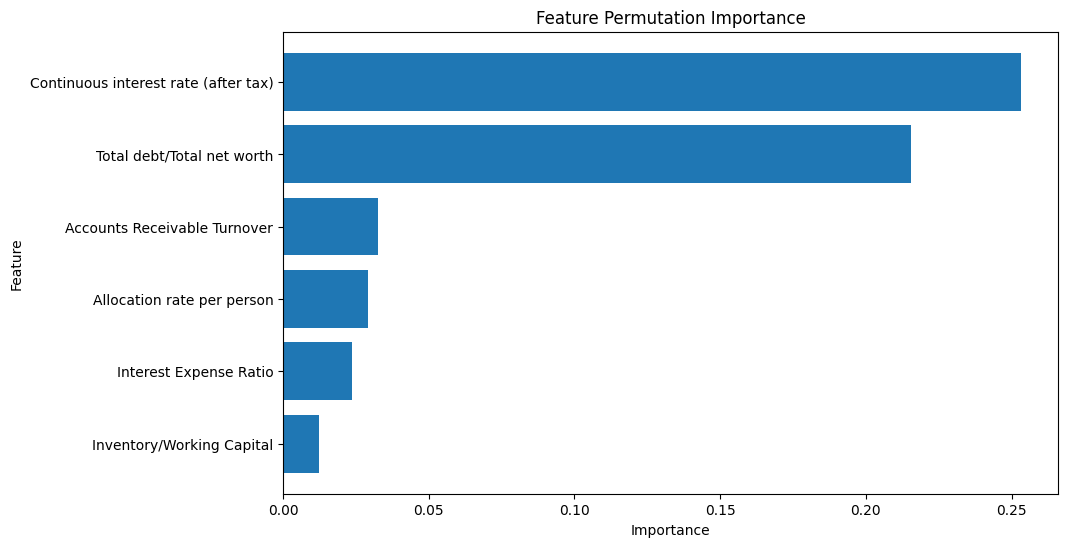

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Allocation rate per person', 'Interest E

In [ ]:
dt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   33  1134  186  11      15.07   75.00        85.91     85.56     25.10   
1   10  1217  103  34       8.85   22.73        92.20     89.96     12.74   
2   10  1217  103  34       8.85   22.73        92.20     89.96     12.74   
3   10  1217  103  34       8.85   22.73        92.20     89.96     12.74   
4    6  1290   30  38      16.67   13.64        97.73     95.01     15.00   
5    9  1281   39  35      18.75   20.45        97.05     94.57     19.57   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               80.45                 0   
1               57.46                 1   
2               57.46                 2   
3               57.46                 3   
4               55.68                 4   
5               58.75                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:46:08.833931

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital',

In [ ]:
dt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   33  1134  186  11      15.07   75.00        85.91     85.56     25.10   
1   33  1130  190  11      14.80   75.00        85.61     85.26     24.72   
2   36  1127  193   8      15.72   81.82        85.38     85.26     26.37   
3   35  1177  143   9      19.66   79.55        89.17     88.86     31.53   
4   34  1156  164  10      17.17   77.27        87.58     87.24     28.10   
5   33  1147  173  11      16.02   75.00        86.89     86.51     26.40   
6   32  1135  185  12      14.75   72.73        85.98     85.56     24.52   
7   32  1132  188  12      14.55   72.73        85.76     85.34     24.24   
8   32  1140  180  12      15.09   72.73        86.36     85.92     25.00   
9   32  1139  181  12      15.02   72.73        86.29     85.85     24.90   
10  32  1141  179  12      15.17   72.73        86.44     86.00     25.10   
11  32  1138  182  12      14.95   72.73        86.21     85.78     24.81   
12  34  1131  189  10      15.25   77.27        85.68     85.41     25.47   
13  36  1111  209   8      14.69   81.82        84.17     84.09     24.91   
14  36  1109  211   8      14.57   81.82        84.02     83.94     24.74   
15  37  1112  208   7      15.10   84.09        84.24     84.24     25.61   
16  37  1110  210   7      14.98   84.09        84.09     84.09     25.43   
17  36  1103  217   8      14.23   81.82        83.56     83.50     24.24   
18  35  1108  212   9      14.17   79.55        83.94     83.80     24.05   
19  36  1113  207   8      14.81   81.82        84.32     84.24     25.09   
20  36  1119  201   8      15.19   81.82        84.77     84.68     25.62   

    balanced_accuracy  num_feat_missing  \
0               80.45                 0   
1               80.30                 1   
2               83.60                 2   
3               84.36                 3   
4               82.42                 4   
5               80.95                 5   
6               79.36                 6   
7               79.24                 7   
8               79.55                 8   
9               79.51                 9   
10              79.58                10   
11              79.47                11   
12              81.48                12   
13              82.99                13   
14              82.92                14   
15              84.17                15   
16              84.09                16   
17              82.69                17   
18              81.74                18   
19              83.07                19   
20              83.30                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'max_depth': [None]
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:51:19.202542

Nested Cross-validation Results:
Individual scores: [0.87212057 0.86880878 0.83308602]
Average nested CV score: 0.858 (+/- 0.035)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.858
2025-01-16 13:51:34.259239

Execution time: 0.25 minutes




```
Starting hyperparameter tuning at: 2025-01-16 02:04:18.627694

Nested Cross-validation Results:
Individual scores: [0.84518008 0.86180447 0.81830489]
Average nested CV score: 0.842 (+/- 0.036)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.858
2025-01-16 03:08:49.850025

Execution time: 64.52 minutes
```



In [ ]:
# rf2_grid_search.cv_results_

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
1                   Borrowing dependency    0.014621  0.006940
2      Retained Earnings to Total Assets    0.013029  0.002305
15            Total income/Total expense    0.011022  0.002264
14                Interest Expense Ratio    0.009412  0.002069
45            Total debt/Total net worth    0.009280  0.003922
..                                   ...         ...       ...
60        Quick Assets/Current Liability   -0.000663  0.002457
41  Long-term fund suitability ratio (A)   -0.000758  0.001186
40     Continuous Net Profit Growth Rate   -0.000777  0.001129
34                Fixed Assets to Assets   -0.001326  0.001357
3            Current Liability to Equity   -0.001705  0.001216

[61 rows x 3 columns]

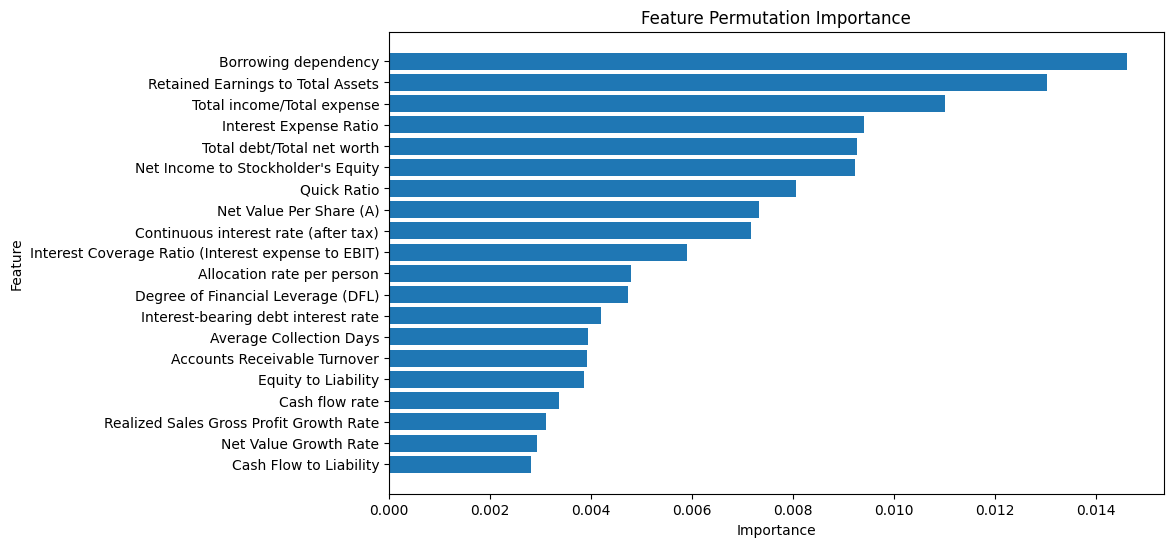

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Borrowing dependency', 'Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total income/Total expense
Original feat removed so far:  ['Borrowing dependency', 'Retained Earnings to Total Assets', 'Total income/Total expense']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Borrowing dependency', 'Retained Earnings to Total Assets', 'Total income/Total expense', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Borrowing dependency', 'Retained Earnings to Total Assets', 'Total income/Total expense', 'Interest Expense Ratio', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Net Income to St

In [ ]:
rf2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1230  90  10      27.42   77.27        93.18     92.67     40.48   
1   33  1247  73  11      31.13   75.00        94.47     93.84     44.00   
2   28  1262  58  16      32.56   63.64        95.61     94.57     43.08   
3   23  1285  35  21      39.66   52.27        97.35     95.89     45.10   
4   19  1301  19  25      50.00   43.18        98.56     96.77     46.34   
5    9  1315   5  35      64.29   20.45        99.62     97.07     31.03   
6    4  1320   0  40     100.00    9.09       100.00     97.07     16.67   
7    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.23                 0   
1               84.73                 1   
2               79.62                 2   
3               74.81                 3   
4               70.87                 4   
5               60.04                 5   
6               54.55                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                    ['Borrowing dependency'] imputed  
2   ['Borrowing dependency', 'Retained Earnings to...  
3   ['Borrowing dependency', 'Retained Earnings to...  
4   ['Borrowing dependency', 'Retained Earnings to...  
5   ['Borrowing dependency', 'Retained Earnings to...  
6   ['Borrowing dependency', 'Retained Earnings to...  
7   ['Borrowing dependency', 'Retained Earnings to...  
8   ['Borrowing dependency', 'Retained Earnings to...  
9   ['Borrowing dependency', 'Retained Earnings to...  
10  ['Borrowing dependency', 'Retained Earnings to...  
11  ['Borrowing dependency', 'Retained Earnings to...  
12  ['Borrowing dependency', 'Retained Earnings to...  
13  ['Borrowing dependency', 'Retained Earnings to...  
14  ['Borrowing dependency', 'Retained Earnings to...  
15  ['Borrowing dependency', 'Retained Earnings to...  
16  ['Borrowing dependency', 'Retained Earnings to...  
17  ['Borrowing dependency', 'Retained Earnings to...  
18  ['Borrowing dependency', 'Retained Earnings to...  
19  ['Borrowing dependency', 'Retained Earnings to...  
20  ['Borrowing dependency', 'Retained Earnings to...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:51:43.685465

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent lia

In [ ]:
rf2_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1230  90  10      27.42   77.27        93.18     92.67     40.48   
1   34  1230  90  10      27.42   77.27        93.18     92.67     40.48   
2   34  1233  87  10      28.10   77.27        93.41     92.89     41.21   
3   34  1235  85  10      28.57   77.27        93.56     93.04     41.72   
4   34  1238  82  10      29.31   77.27        93.79     93.26     42.50   
5   36  1241  79   8      31.30   81.82        94.02     93.62     45.28   
6   34  1245  75  10      31.19   77.27        94.32     93.77     44.44   
7   32  1247  73  12      30.48   72.73        94.47     93.77     42.95   
8   30  1261  59  14      33.71   68.18        95.53     94.65     45.11   
9   29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
10  29  1270  50  15      36.71   65.91        96.21     95.23     47.15   
11  28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
12  27  1276  44  17      38.03   61.36        96.67     95.53     46.96   
13  26  1275  45  18      36.62   59.09        96.59     95.38     45.22   
14  26  1273  47  18      35.62   59.09        96.44     95.23     44.44   
15  26  1274  46  18      36.11   59.09        96.52     95.31     44.83   
16  22  1289  31  22      41.51   50.00        97.65     96.11     45.36   
17  21  1290  30  23      41.18   47.73        97.73     96.11     44.21   
18  21  1292  28  23      42.86   47.73        97.88     96.26     45.16   
19  16  1298  22  28      42.11   36.36        98.33     96.33     39.02   
20  17  1298  22  27      43.59   38.64        98.33     96.41     40.96   

    balanced_accuracy  num_feat_missing  \
0               85.23                 0   
1               85.23                 1   
2               85.34                 2   
3               85.42                 3   
4               85.53                 4   
5               87.92                 5   
6               85.80                 6   
7               83.60                 7   
8               81.86                 8   
9               80.95                 9   
10              81.06                10   
11              79.89                11   
12              79.02                12   
13              77.84                13   
14              77.77                14   
15              77.80                15   
16              73.83                16   
17              72.73                17   
18              72.80                18   
19              67.35                19   
20              68.48                20   

                                              imputed  
0                                                      
1                    ['Borrowing dependency'] imputed  
2   ['Borrowing dependency', 'Retained Earnings to...  
3   ['Borrowing dependency', 'Retained Earnings to...  
4   ['Borrowing dependency', 'Retained Earnings to...  
5   ['Borrowing dependency', 'Retained Earnings to...  
6   ['Borrowing dependency', 'Retained Earnings to...  
7   ['Borrowing dependency', 'Retained Earnings to...  
8   ['Borrowing dependency', 'Retained Earnings to...  
9   ['Borrowing dependency', 'Retained Earnings to...  
10  ['Borrowing dependency', 'Retained Earnings to...  
11  ['Borrowing dependency', 'Retained Earnings to...  
12  ['Borrowing dependency', 'Retained Earnings to...  
13  ['Borrowing dependency', 'Retained Earnings to...  
14  ['Borrowing dependency', 'Retained Earnings to...  
15  ['Borrowing dependency', 'Retained Earnings to...  
16  ['Borrowing dependency', 'Retained Earnings to...  
17  ['Borrowing dependency', 'Retained Earnings to...  
18  ['Borrowing dependency', 'Retained Earnings to...  
19  ['Borrowing dependency', 'Retained Earnings to...  
20  ['Borrowing dependency', 'Retained Earnings to...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1.0, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'min_child_samples': [25],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt2_classifier = LGBMClassifier(
    # class_weight='balanced',
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:56:56.164650

Nested Cross-validation Results:
Individual scores: [0.84494414 0.83612853 0.84491863]
Average nested CV score: 0.842 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.842
2025-01-16 13:57:00.340124

Execution time: 0.07 minutes




```
Starting hyperparameter tuning at: 2025-01-13 02:38:19.428751

Nested Cross-validation Results:
Individual scores: [0.87462924 0.81263715 0.82063191]
Average nested CV score: 0.836 (+/- 0.055)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.843
2025-01-13 02:45:44.987140

Execution time: 7.43 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 17:06:48.736998

Nested Cross-validation Results:
Individual scores: [0.82856317 0.82949647 0.84435012]
Average nested CV score: 0.834 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.842
2025-01-15 17:14:14.304317

Execution time: 7.43 minutes
```



In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
2                   Retained Earnings to Total Assets    0.136454  0.013844
45                         Total debt/Total net worth    0.074675  0.006516
55                       Accounts Receivable Turnover    0.027973  0.005961
52                         Allocation rate per person    0.025322  0.006328
47                Interest-bearing debt interest rate    0.016003  0.002887
23                               Total expense/Assets    0.014830  0.003464
43                                        Quick Ratio    0.011931  0.002387
11                        Operating profit per person    0.011364  0.003114
22                                  Cash/Total Assets    0.007992  0.001918
35                              Net Value Growth Rate    0.005984  0.000351
50                    Inventory Turnover Rate (times)    0.005890  0.002943
1                                Borrowing dependency    0.005188  0.002542
5                             Net Value Per Share (A)    0.003826  0.001237
8                Continuous interest rate (after tax)    0.003730  0.003080
42                                 Revenue per person    0.003580  0.001360
44                                 Cash Turnover Rate    0.003087  0.000948
20               Total Asset Return Growth Rate Ratio    0.002898  0.000142
40                  Continuous Net Profit Growth Rate    0.002594  0.003439
15                         Total income/Total expense    0.002575  0.001251
60                     Quick Assets/Current Liability    0.002368  0.000268
33                          Quick Assets/Total Assets    0.002216  0.001802
59                             Operating Expense Rate    0.001970  0.001341
58                         Revenue Per Share (Yuan ¥)    0.001913  0.001570
19        Inventory and accounts receivable/Net value    0.001894  0.001431
31                             Cash Flow to Liability    0.001894  0.003345
48                     Current Liability to Liability    0.001742  0.001427
21                                Cash Flow Per Share    0.001553  0.001403
49                          Quick Asset Turnover Rate    0.001515  0.001751
27                                Cash Flow to Equity    0.001402  0.001500
34                             Fixed Assets to Assets    0.001401  0.001115
24                   After-tax Net Profit Growth Rate    0.000985  0.001077
56                            Average Collection Days    0.000928  0.001153
32                               Total Asset Turnover    0.000776  0.002328
37                       Operating Profit Growth Rate    0.000455  0.000093
36                            Total Asset Growth Rate    0.000322  0.000204
13                                       Tax rate (A)    0.000189  0.000169
29                   Contingent liabilities/Net worth    0.000152  0.000272
0                  Net Income to Stockholder's Equity    0.000095  0.000085
4                 Current Liability to Current Assets    0.000038  0.000046
25                                 No-credit Interval    0.000019  0.001043
38                    Fixed Assets Turnover Frequency   -0.000057  0.000046
9                       Equity to Long-term Liability   -0.000076  0.000264
18                                     Cash flow rate   -0.000152  0.001077
16  Interest Coverage Ratio (Interest expense to E...   -0.000170  0.000071
51                          Total assets to GNP price   -0.000398  0.000139
10                                Equity to Liability   -0.000417  0.000165
3                         Current Liability to Equity   -0.000682  0.000184
46              Research and development expense rate   -0.001818  0.001057

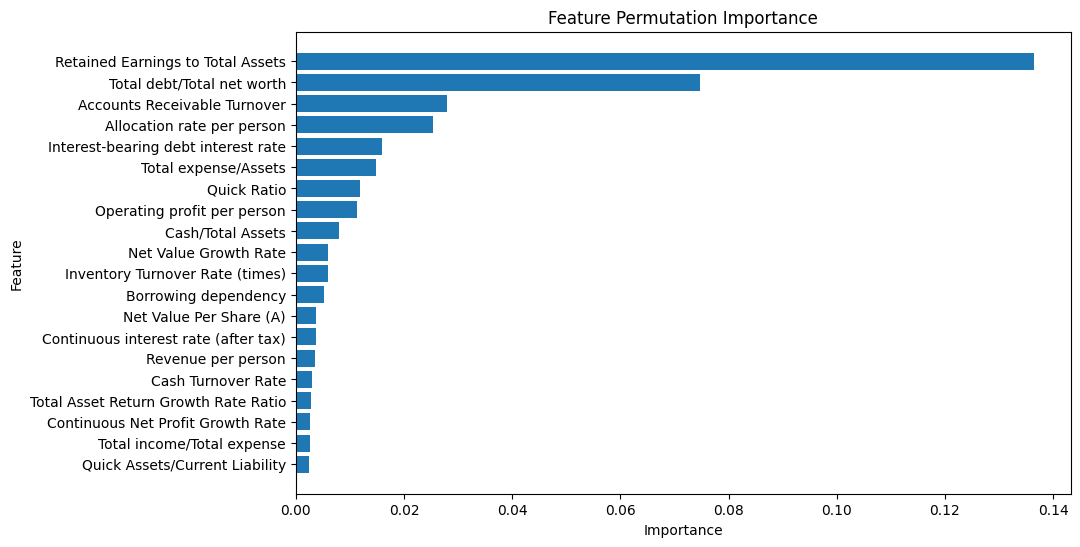

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Allocation rate per person', 'Interest-bearin

In [ ]:
gbt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1210  110   9      24.14   79.55        91.67     91.28     37.04   
1   22  1287   33  22      40.00   50.00        97.50     95.97     44.44   
2   16  1298   22  28      42.11   36.36        98.33     96.33     39.02   
3   14  1306   14  30      50.00   31.82        98.94     96.77     38.89   
4    7  1316    4  37      63.64   15.91        99.70     96.99     25.45   
5    4  1318    2  40      66.67    9.09        99.85     96.92     16.00   
6    2  1318    2  42      50.00    4.55        99.85     96.77      8.33   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.61                 0   
1               73.75                 1   
2               67.35                 2   
3               65.38                 3   
4               57.80                 4   
5               54.47                 5   
6               52.20                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1       ['Retained Earnings to Total Assets'] imputed  
2   ['Retained Earnings to Total Assets', 'Total d...  
3   ['Retained Earnings to Total Assets', 'Total d...  
4   ['Retained Earnings to Total Assets', 'Total d...  
5   ['Retained Earnings to Total Assets', 'Total d...  
6   ['Retained Earnings to Total Assets', 'Total d...  
7   ['Retained Earnings to Total Assets', 'Total d...  
8   ['Retained Earnings to Total Assets', 'Total d...  
9   ['Retained Earnings to Total Assets', 'Total d...  
10  ['Retained Earnings to Total Assets', 'Total d...  
11  ['Retained Earnings to Total Assets', 'Total d...  
12  ['Retained Earnings to Total Assets', 'Total d...  
13  ['Retained Earnings to Total Assets', 'Total d...  
14  ['Retained Earnings to Total Assets', 'Total d...  
15  ['Retained Earnings to Total Assets', 'Total d...  
16  ['Retained Earnings to Total Assets', 'Total d...  
17  ['Retained Earnings to Total Assets', 'Total d...  
18  ['Retained Earnings to Total Assets', 'Total d...  
19  ['Retained Earnings to Total Assets', 'Total d...  
20  ['Retained Earnings to Total Assets', 'Total d...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:57:02.974462

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'C

In [ ]:
gbt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1210  110   9      24.14   79.55        91.67     91.28     37.04   
1   35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
2   36  1186  134   8      21.18   81.82        89.85     89.59     33.64   
3   34  1214  106  10      24.29   77.27        91.97     91.50     36.96   
4   36  1209  111   8      24.49   81.82        91.59     91.28     37.70   
5   37  1184  136   7      21.39   84.09        89.70     89.52     34.10   
6   37  1181  139   7      21.02   84.09        89.47     89.30     33.64   
7   32  1230   90  12      26.23   72.73        93.18     92.52     38.55   
8   32  1228   92  12      25.81   72.73        93.03     92.38     38.10   
9   29  1232   88  15      24.79   65.91        93.33     92.45     36.02   
10  29  1244   76  15      27.62   65.91        94.24     93.33     38.93   
11  30  1249   71  14      29.70   68.18        94.62     93.77     41.38   
12  28  1259   61  16      31.46   63.64        95.38     94.35     42.11   
13  20  1270   50  24      28.57   45.45        96.21     94.57     35.09   
14  19  1269   51  25      27.14   43.18        96.14     94.43     33.33   
15  19  1266   54  25      26.03   43.18        95.91     94.21     32.48   
16  19  1266   54  25      26.03   43.18        95.91     94.21     32.48   
17  18  1264   56  26      24.32   40.91        95.76     93.99     30.51   
18  17  1264   56  27      23.29   38.64        95.76     93.91     29.06   
19  16  1266   54  28      22.86   36.36        95.91     93.99     28.07   
20  15  1270   50  29      23.08   34.09        96.21     94.21     27.52   

    balanced_accuracy  num_feat_missing  \
0               85.61                 0   
1               85.30                 1   
2               85.83                 2   
3               84.62                 3   
4               86.70                 4   
5               86.89                 5   
6               86.78                 6   
7               82.95                 7   
8               82.88                 8   
9               79.62                 9   
10              80.08                10   
11              81.40                11   
12              79.51                12   
13              70.83                13   
14              69.66                14   
15              69.55                15   
16              69.55                16   
17              68.33                17   
18              67.20                18   
19              66.14                19   
20              65.15                20   

                                              imputed  
0                                                      
1       ['Retained Earnings to Total Assets'] imputed  
2   ['Retained Earnings to Total Assets', 'Total d...  
3   ['Retained Earnings to Total Assets', 'Total d...  
4   ['Retained Earnings to Total Assets', 'Total d...  
5   ['Retained Earnings to Total Assets', 'Total d...  
6   ['Retained Earnings to Total Assets', 'Total d...  
7   ['Retained Earnings to Total Assets', 'Total d...  
8   ['Retained Earnings to Total Assets', 'Total d...  
9   ['Retained Earnings to Total Assets', 'Total d...  
10  ['Retained Earnings to Total Assets', 'Total d...  
11  ['Retained Earnings to Total Assets', 'Total d...  
12  ['Retained Earnings to Total Assets', 'Total d...  
13  ['Retained Earnings to Total Assets', 'Total d...  
14  ['Retained Earnings to Total Assets', 'Total d...  
15  ['Retained Earnings to Total Assets', 'Total d...  
16  ['Retained Earnings to Total Assets', 'Total d...  
17  ['Retained Earnings to Total Assets', 'Total d...  
18  ['Retained Earnings to Total Assets', 'Total d...  
19  ['Retained Earnings to Total Assets', 'Total d...  
20  ['Retained Earnings to Total Assets', 'Total d...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for tree splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [0.05],
    'colsample_bytree':[1.0]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:02:17.776424

Nested Cross-validation Results:
Individual scores: [0.83377311 0.80485893 0.79195614]
Average nested CV score: 0.810 (+/- 0.035)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.05, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.810
2025-01-16 14:02:21.792205

Execution time: 0.07 minutes




```
Starting hyperparameter tuning at: 2025-01-13 02:09:56.887533

Nested Cross-validation Results:
Individual scores: [0.59037943 0.6359424  0.65874293]
Average nested CV score: 0.628 (+/- 0.057)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.667
2025-01-13 02:30:42.096814

Execution time: 20.75 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 17:14:14.315291

Nested Cross-validation Results:
Individual scores: [0.77104199 0.80656348 0.79053488]
Average nested CV score: 0.789 (+/- 0.029)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.05, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.810
2025-01-15 17:33:42.780365

Execution time: 19.47 minutes
```


In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
52                         Allocation rate per person    0.012576  0.001683
55                       Accounts Receivable Turnover    0.010436  0.002045
47                Interest-bearing debt interest rate    0.006534  0.003770
8                Continuous interest rate (after tax)    0.004392  0.005886
11                        Operating profit per person    0.002917  0.000408
24                   After-tax Net Profit Growth Rate    0.001705  0.000305
6                              Working Capital/Equity    0.001686  0.000302
43                                        Quick Ratio    0.001628  0.002297
42                                 Revenue per person    0.001515  0.001590
48                     Current Liability to Liability    0.001421  0.000419
33                          Quick Assets/Total Assets    0.001288  0.000285
46              Research and development expense rate    0.001099  0.000489
19        Inventory and accounts receivable/Net value    0.000606  0.000128
27                                Cash Flow to Equity    0.000606  0.000265
50                    Inventory Turnover Rate (times)    0.000568  0.000512
17                             Operating Gross Margin    0.000549  0.000290
59                             Operating Expense Rate    0.000474  0.000261
4                 Current Liability to Current Assets    0.000455  0.000308
26                             Cash/Current Liability    0.000436  0.000142
5                             Net Value Per Share (A)    0.000397  0.000202
40                  Continuous Net Profit Growth Rate    0.000360  0.000174
29                   Contingent liabilities/Net worth    0.000360  0.000235
7                 Operating Profit Per Share (Yuan ¥)    0.000284  0.000104
38                    Fixed Assets Turnover Frequency    0.000265  0.000184
37                       Operating Profit Growth Rate    0.000227  0.000229
25                                 No-credit Interval    0.000170  0.000110
34                             Fixed Assets to Assets    0.000114  0.000446
9                       Equity to Long-term Liability    0.000114  0.000110
49                          Quick Asset Turnover Rate    0.000095  0.000328
23                               Total expense/Assets    0.000057  0.000320
54                        Current Asset Turnover Rate    0.000038  0.000213
39            Realized Sales Gross Profit Growth Rate   -0.000038  0.000221
30                 Degree of Financial Leverage (DFL)   -0.000114  0.000093
41               Long-term fund suitability ratio (A)   -0.000133  0.000204
56                            Average Collection Days   -0.000133  0.000128
16  Interest Coverage Ratio (Interest expense to E...   -0.000189  0.000134
51                          Total assets to GNP price   -0.000189  0.000208
44                                 Cash Turnover Rate   -0.000208  0.000271
58                         Revenue Per Share (Yuan ¥)   -0.000265  0.000412
20               Total Asset Return Growth Rate Ratio   -0.000284  0.000104
10                                Equity to Liability   -0.000284  0.000169
57                        Inventory/Current Liability   -0.000322  0.000176
22                                  Cash/Total Assets   -0.000606  0.000097
14                             Interest Expense Ratio   -0.000625  0.000114
18                                     Cash flow rate   -0.000644  0.000336
21                                Cash Flow Per Share   -0.000720  0.000320
3                         Current Liability to Equity   -0.000947  0.000240
36                            Total Asset Growth Rate   -0.001004  0.000128
13                                       Tax rate (A)   -0.001156  0.000110
31                             Cash Flow to Liability   -0.001496  0.000632
2                   Retained Earnings to Total Assets   -0.001743  0.000154
35                              Net Value Growth Rate   -0.001857  0.001283
32                

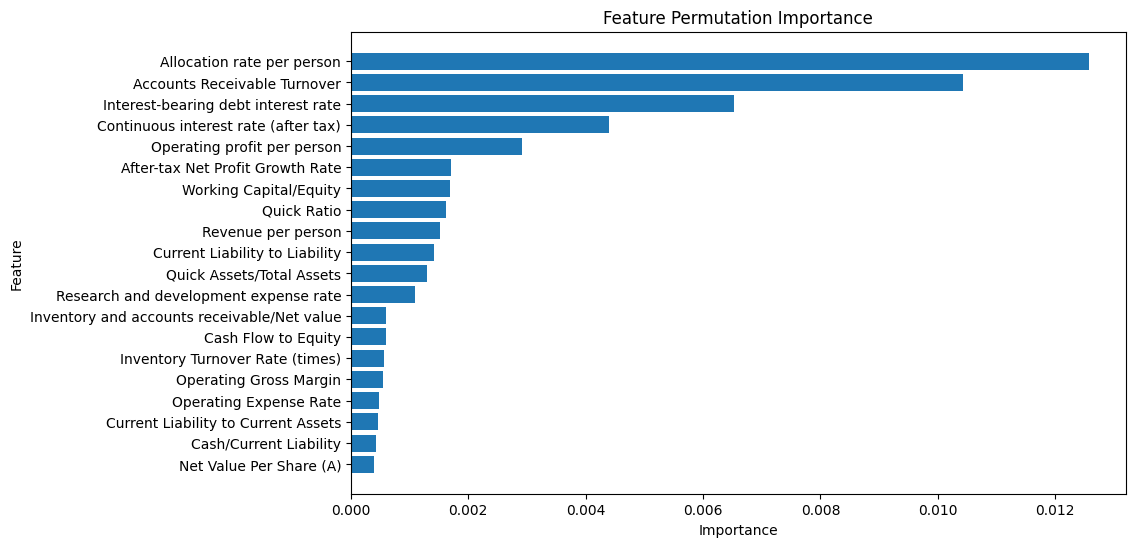

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover', 'Interest-bearing debt interest rate', 'Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Operating profit per person
Original feat removed so far:  ['Allocation rate per person', 'Accounts Receivable Turnover', 'Interest-bearing debt interest rate', 'Continuous interest rate (after tax)'

In [ ]:
xgb2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1264  56  17      32.53   61.36        95.76     94.65     42.52   
1   26  1269  51  18      33.77   59.09        96.14     94.94     42.98   
2   25  1272  48  19      34.25   56.82        96.36     95.09     42.74   
3   23  1284  36  21      38.98   52.27        97.27     95.82     44.66   
4    9  1307  13  35      40.91   20.45        99.02     96.48     27.27   
5    9  1309  11  35      45.00   20.45        99.17     96.63     28.12   
6   10  1309  11  34      47.62   22.73        99.17     96.70     30.77   
7   12  1307  13  32      48.00   27.27        99.02     96.70     34.78   
8    3  1319   1  41      75.00    6.82        99.92     96.92     12.50   
9    4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
10   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
11   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
12   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
13   5  1318   2  39      71.43   11.36        99.85     96.99     19.61   
14   4  1318   2  40      66.67    9.09        99.85     96.92     16.00   
15   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
16   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
17   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
18   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
19   4  1319   1  40      80.00    9.09        99.92     96.99     16.33   
20   1  1320   0  43     100.00    2.27       100.00     96.85      4.44   

    balanced_accuracy  num_feat_missing  \
0               78.56                 0   
1               77.61                 1   
2               76.59                 2   
3               74.77                 3   
4               59.73                 4   
5               59.81                 5   
6               60.95                 6   
7               63.14                 7   
8               53.37                 8   
9               54.51                 9   
10              54.51                10   
11              54.51                11   
12              54.51                12   
13              55.61                13   
14              54.47                14   
15              54.51                15   
16              54.51                16   
17              54.51                17   
18              54.51                18   
19              54.51                19   
20              51.14                20   

                                              imputed  
0                                                      
1              ['Allocation rate per person'] imputed  
2   ['Allocation rate per person', 'Accounts Recei...  
3   ['Allocation rate per person', 'Accounts Recei...  
4   ['Allocation rate per person', 'Accounts Recei...  
5   ['Allocation rate per person', 'Accounts Recei...  
6   ['Allocation rate per person', 'Accounts Recei...  
7   ['Allocation rate per person', 'Accounts Recei...  
8   ['Allocation rate per person', 'Accounts Recei...  
9   ['Allocation rate per person', 'Accounts Recei...  
10  ['Allocation rate per person', 'Accounts Recei...  
11  ['Allocation rate per person', 'Accounts Recei...  
12  ['Allocation rate per person', 'Accounts Recei...  
13  ['Allocation rate per person', 'Accounts Recei...  
14  ['Allocation rate per person', 'Accounts Recei...  
15  ['Allocation rate per person', 'Accounts Recei...  
16  ['Allocation rate per person', 'Accounts Recei...  
17  ['Allocation rate per person', 'Accounts Recei...  
18  ['Allocation rate per person', 'Accounts Recei...  
19  ['Allocation rate per person', 'Accounts Recei...  
20  ['Allocation rate per person', 'Accounts Recei...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:02:24.587367

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Continge

In [ ]:
xgb2_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1264  56  17      32.53   61.36        95.76     94.65     42.52   
1   27  1261  59  17      31.40   61.36        95.53     94.43     41.54   
2   26  1275  45  18      36.62   59.09        96.59     95.38     45.22   
3   27  1267  53  17      33.75   61.36        95.98     94.87     43.55   
4   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
5   28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
6   27  1267  53  17      33.75   61.36        95.98     94.87     43.55   
7   26  1267  53  18      32.91   59.09        95.98     94.79     42.28   
8   14  1304  16  30      46.67   31.82        98.79     96.63     37.84   
9   14  1303  17  30      45.16   31.82        98.71     96.55     37.33   
10  13  1303  17  31      43.33   29.55        98.71     96.48     35.14   
11  13  1302  18  31      41.94   29.55        98.64     96.41     34.67   
12  15  1298  22  29      40.54   34.09        98.33     96.26     37.04   
13  16  1294  26  28      38.10   36.36        98.03     96.04     37.21   
14  16  1293  27  28      37.21   36.36        97.95     95.97     36.78   
15  16  1297  23  28      41.03   36.36        98.26     96.26     38.55   
16  16  1297  23  28      41.03   36.36        98.26     96.26     38.55   
17  17  1300  20  27      45.95   38.64        98.48     96.55     41.98   
18  16  1301  19  28      45.71   36.36        98.56     96.55     40.51   
19  19  1290  30  25      38.78   43.18        97.73     95.97     40.86   
20  18  1292  28  26      39.13   40.91        97.88     96.04     40.00   

    balanced_accuracy  num_feat_missing  \
0               78.56                 0   
1               78.45                 1   
2               77.84                 2   
3               78.67                 3   
4               79.73                 4   
5               79.70                 5   
6               78.67                 6   
7               77.54                 7   
8               65.30                 8   
9               65.27                 9   
10              64.13                10   
11              64.09                11   
12              66.21                12   
13              67.20                13   
14              67.16                14   
15              67.31                15   
16              67.31                16   
17              68.56                17   
18              67.46                18   
19              70.45                19   
20              69.39                20   

                                              imputed  
0                                                      
1              ['Allocation rate per person'] imputed  
2   ['Allocation rate per person', 'Accounts Recei...  
3   ['Allocation rate per person', 'Accounts Recei...  
4   ['Allocation rate per person', 'Accounts Recei...  
5   ['Allocation rate per person', 'Accounts Recei...  
6   ['Allocation rate per person', 'Accounts Recei...  
7   ['Allocation rate per person', 'Accounts Recei...  
8   ['Allocation rate per person', 'Accounts Recei...  
9   ['Allocation rate per person', 'Accounts Recei...  
10  ['Allocation rate per person', 'Accounts Recei...  
11  ['Allocation rate per person', 'Accounts Recei...  
12  ['Allocation rate per person', 'Accounts Recei...  
13  ['Allocation rate per person', 'Accounts Recei...  
14  ['Allocation rate per person', 'Accounts Recei...  
15  ['Allocation rate per person', 'Accounts Recei...  
16  ['Allocation rate per person', 'Accounts Recei...  
17  ['Allocation rate per person', 'Accounts Recei...  
18  ['Allocation rate per person', 'Accounts Recei...  
19  ['Allocation rate per person', 'Accounts Recei...  
20  ['Allocation rate per person', 'Accounts Recei...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [200],
      'max_depth': [5],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.005]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:07:38.964263

Nested Cross-validation Results:
Individual scores: [0.87050751 0.88123041 0.857498  ]
Average nested CV score: 0.870 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.870
2025-01-16 14:07:45.087134

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-15 17:33:42.794923

Nested Cross-validation Results:
Individual scores: [0.86193663 0.88123041 0.85119145]
Average nested CV score: 0.865 (+/- 0.025)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.870
2025-01-15 17:53:57.922608

Execution time: 20.25 minutes
```



In [ ]:
# et2_grid_search.cv_results_

In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
13                                       Tax rate (A)    0.019163  0.004084
16  Interest Coverage Ratio (Interest expense to E...    0.003712  0.001156
29                   Contingent liabilities/Net worth    0.002803  0.000154
22                                  Cash/Total Assets    0.002177  0.004223
46              Research and development expense rate    0.000758  0.001101
17                             Operating Gross Margin    0.000644  0.001570
31                             Cash Flow to Liability    0.000473  0.001406
42                                 Revenue per person    0.000322  0.000142
21                                Cash Flow Per Share    0.000322  0.001720
32                               Total Asset Turnover    0.000303  0.001358
20               Total Asset Return Growth Rate Ratio    0.000284  0.000120
39            Realized Sales Gross Profit Growth Rate    0.000265  0.000110
48                     Current Liability to Liability    0.000246  0.000186
43                                        Quick Ratio    0.000227  0.001285
37                       Operating Profit Growth Rate    0.000152  0.000186
49                          Quick Asset Turnover Rate    0.000152  0.000176
59                             Operating Expense Rate    0.000133  0.000204
45                         Total debt/Total net worth    0.000132  0.001278
40                  Continuous Net Profit Growth Rate    0.000057  0.000046
24                   After-tax Net Profit Growth Rate    0.000019  0.000093
50                    Inventory Turnover Rate (times)    0.000019  0.000071
51                          Total assets to GNP price   -0.000038  0.000165
25                                 No-credit Interval   -0.000038  0.000097
53              Long-term Liability to Current Assets   -0.000038  0.000046
44                                 Cash Turnover Rate   -0.000057  0.001026
35                              Net Value Growth Rate   -0.000057  0.000097
54                        Current Asset Turnover Rate   -0.000076  0.000152
41               Long-term fund suitability ratio (A)   -0.000076  0.000038
28                          Inventory/Working Capital   -0.000076  0.000071
18                                     Cash flow rate   -0.000095  0.001711
52                         Allocation rate per person   -0.000114  0.000110
26                             Cash/Current Liability   -0.000133  0.000154
56                            Average Collection Days   -0.000133  0.000076
61                                      Current Ratio   -0.000133  0.002097
58                         Revenue Per Share (Yuan ¥)   -0.000189  0.000224
34                             Fixed Assets to Assets   -0.000303  0.000202
8                Continuous interest rate (after tax)   -0.000322  0.000154
47                Interest-bearing debt interest rate   -0.000341  0.000128
9                       Equity to Long-term Liability   -0.000436  0.000320
36                            Total Asset Growth Rate   -0.000664  0.006396
14                             Interest Expense Ratio   -0.000758  0.000134
30                 Degree of Financial Leverage (DFL)   -0.000777  0.000071
60                     Quick Assets/Current Liability   -0.000852  0.000354
6                              Working Capital/Equity   -0.000928  0.000835
33                          Quick Assets/Total Assets   -0.001042  0.001020
38                    Fixed Assets Turnover Frequency   -0.001193  0.001128
19        Inventory and accounts receivable/Net value   -0.001269  0.002916
27                                Cash Flow to Equity   -0.001269  0.001361
3                         Current Liability to Equity   -0.001383  0.002039
23                               Total expense/Assets   -0.001591  0.001055
11                        Operating profit per person   -0.001837  0.001976
1                                Borrowing dependency   -0.001876  0.002198
10                

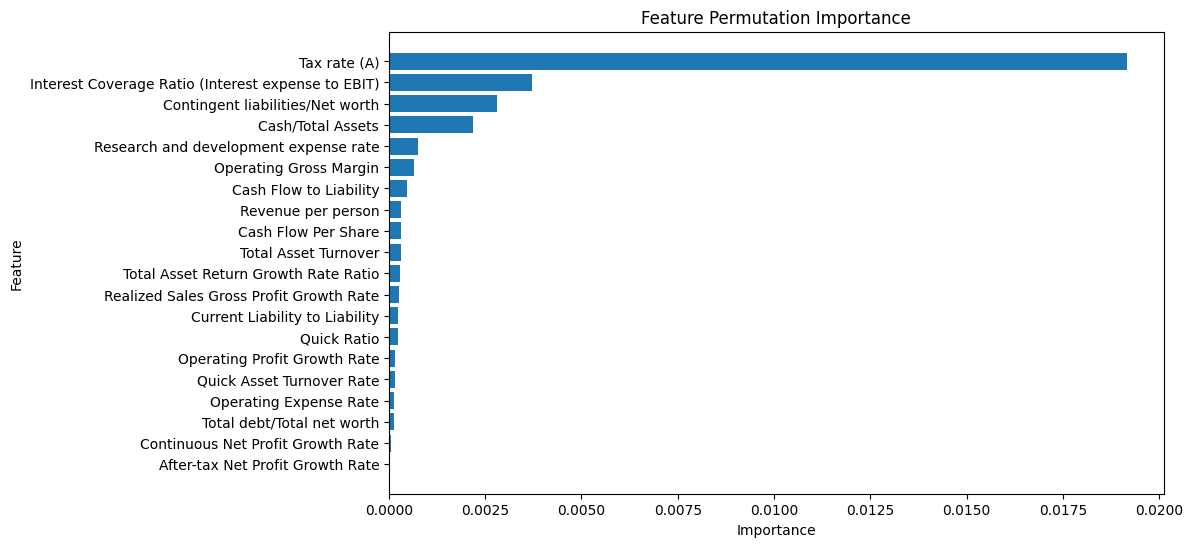

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Tax rate (A)
Original feat removed so far:  ['Tax rate (A)']

--- NEW ITERATION ---
Removing feature:  Interest Coverage Ratio (Interest expense to EBIT)
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)']

--- NEW ITERATION ---
Removing feature:  Contingent liabilities/Net worth
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Contingent liabilities/Net worth']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Contingent liabilities/Net worth', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Research and development expense rate
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Contingent liabilities/Net worth', 'Cash/Total Assets', 'Research and development expen

In [ ]:
et2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1135  185   4      17.78   90.91        85.98     86.14     29.74   
1   35  1206  114   9      23.49   79.55        91.36     90.98     36.27   
2   33  1220  100  11      24.81   75.00        92.42     91.86     37.29   
3   33  1220  100  11      24.81   75.00        92.42     91.86     37.29   
4   31  1227   93  13      25.00   70.45        92.95     92.23     36.90   
5   31  1227   93  13      25.00   70.45        92.95     92.23     36.90   
6   31  1230   90  13      25.62   70.45        93.18     92.45     37.58   
7   31  1230   90  13      25.62   70.45        93.18     92.45     37.58   
8   31  1230   90  13      25.62   70.45        93.18     92.45     37.58   
9   30  1231   89  14      25.21   68.18        93.26     92.45     36.81   
10  30  1232   88  14      25.42   68.18        93.33     92.52     37.04   
11  30  1234   86  14      25.86   68.18        93.48     92.67     37.50   
12  30  1234   86  14      25.86   68.18        93.48     92.67     37.50   
13  30  1235   85  14      26.09   68.18        93.56     92.74     37.74   
14  30  1240   80  14      27.27   68.18        93.94     93.11     38.96   
15  30  1240   80  14      27.27   68.18        93.94     93.11     38.96   
16  30  1242   78  14      27.78   68.18        94.09     93.26     39.47   
17  30  1241   79  14      27.52   68.18        94.02     93.18     39.22   
18  29  1244   76  15      27.62   65.91        94.24     93.33     38.93   
19  29  1244   76  15      27.62   65.91        94.24     93.33     38.93   
20  29  1244   76  15      27.62   65.91        94.24     93.33     38.93   

    balanced_accuracy  num_feat_missing  \
0               88.45                 0   
1               85.45                 1   
2               83.71                 2   
3               83.71                 3   
4               81.70                 4   
5               81.70                 5   
6               81.82                 6   
7               81.82                 7   
8               81.82                 8   
9               80.72                 9   
10              80.76                10   
11              80.83                11   
12              80.83                12   
13              80.87                13   
14              81.06                14   
15              81.06                15   
16              81.14                16   
17              81.10                17   
18              80.08                18   
19              80.08                19   
20              80.08                20   

                                              imputed  
0                                                      
1                            ['Tax rate (A)'] imputed  
2   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
3   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
4   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
5   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
6   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
7   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
8   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
9   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
10  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
11  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
12  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
13  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
14  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
15  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
16  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
17  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
18  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
19  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
20  ['Tax rate (A)', 'Interest Coverage Ratio (Int...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:07:50.292583

--- NEW ITERATION ---
Removing feature:  Tax rate (A)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent liabilities

In [ ]:
et2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1135  185   4      17.78   90.91        85.98     86.14     29.74   
1   36  1191  129   8      21.82   81.82        90.23     89.96     34.45   
2   36  1195  125   8      22.36   81.82        90.53     90.25     35.12   
3   36  1196  124   8      22.50   81.82        90.61     90.32     35.29   
4   36  1204  116   8      23.68   81.82        91.21     90.91     36.73   
5   36  1208  112   8      24.32   81.82        91.52     91.20     37.50   
6   34  1201  119  10      22.22   77.27        90.98     90.54     34.52   
7   34  1202  118  10      22.37   77.27        91.06     90.62     34.69   
8   34  1201  119  10      22.22   77.27        90.98     90.54     34.52   
9   35  1200  120   9      22.58   79.55        90.91     90.54     35.18   
10  34  1207  113  10      23.13   77.27        91.44     90.98     35.60   
11  34  1207  113  10      23.13   77.27        91.44     90.98     35.60   
12  33  1209  111  11      22.92   75.00        91.59     91.06     35.11   
13  35  1210  110   9      24.14   79.55        91.67     91.28     37.04   
14  32  1219  101  12      24.06   72.73        92.35     91.72     36.16   
15  32  1217  103  12      23.70   72.73        92.20     91.57     35.75   
16  32  1215  105  12      23.36   72.73        92.05     91.42     35.36   
17  32  1214  106  12      23.19   72.73        91.97     91.35     35.16   
18  32  1214  106  12      23.19   72.73        91.97     91.35     35.16   
19  32  1215  105  12      23.36   72.73        92.05     91.42     35.36   
20  32  1215  105  12      23.36   72.73        92.05     91.42     35.36   

    balanced_accuracy  num_feat_missing  \
0               88.45                 0   
1               86.02                 1   
2               86.17                 2   
3               86.21                 3   
4               86.52                 4   
5               86.67                 5   
6               84.13                 6   
7               84.17                 7   
8               84.13                 8   
9               85.23                 9   
10              84.36                10   
11              84.36                11   
12              83.30                12   
13              85.61                13   
14              82.54                14   
15              82.46                15   
16              82.39                16   
17              82.35                17   
18              82.35                18   
19              82.39                19   
20              82.39                20   

                                              imputed  
0                                                      
1                            ['Tax rate (A)'] imputed  
2   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
3   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
4   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
5   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
6   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
7   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
8   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
9   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
10  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
11  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
12  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
13  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
14  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
15  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
16  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
17  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
18  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
19  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
20  ['Tax rate (A)', 'Interest Coverage Ratio (Int...

##**Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [5.0],
    'kernel': ['poly'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:13:06.632103

Nested Cross-validation Results:
Individual scores: [0.81847554 0.81757445 0.80830306]
Average nested CV score: 0.815 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.815
2025-01-16 14:13:11.326534

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-15 17:53:57.932288

Nested Cross-validation Results:
Individual scores: [0.79276772 0.82069945 0.84509689]
Average nested CV score: 0.820 (+/- 0.043)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 5, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.815
2025-01-15 18:00:06.511189

Execution time: 6.14 minutes
```



In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
22                                  Cash/Total Assets    0.050131  0.006277
32                               Total Asset Turnover    0.040985  0.005950
33                          Quick Assets/Total Assets    0.031841  0.005984
10                                Equity to Liability    0.021060  0.005347
38                    Fixed Assets Turnover Frequency    0.018807  0.003691
49                          Quick Asset Turnover Rate    0.011099  0.004647
31                             Cash Flow to Liability    0.007424  0.002547
13                                       Tax rate (A)    0.006174  0.004016
2                   Retained Earnings to Total Assets    0.006078  0.002974
23                               Total expense/Assets    0.005985  0.006882
36                            Total Asset Growth Rate    0.005985  0.007063
47                Interest-bearing debt interest rate    0.004943  0.002670
59                             Operating Expense Rate    0.004053  0.002075
50                    Inventory Turnover Rate (times)    0.003978  0.001925
48                     Current Liability to Liability    0.003599  0.004526
4                 Current Liability to Current Assets    0.003427  0.002248
12                              Liability-Assets Flag    0.003352  0.000076
45                         Total debt/Total net worth    0.002992  0.000097
39            Realized Sales Gross Profit Growth Rate    0.002992  0.000213
5                             Net Value Per Share (A)    0.002669  0.000742
44                                 Cash Turnover Rate    0.002500  0.005199
51                          Total assets to GNP price    0.002273  0.001949
27                                Cash Flow to Equity    0.002046  0.001199
54                        Current Asset Turnover Rate    0.001591  0.000957
9                       Equity to Long-term Liability    0.001439  0.001048
55                       Accounts Receivable Turnover    0.001269  0.001400
19        Inventory and accounts receivable/Net value    0.001231  0.003333
57                        Inventory/Current Liability    0.000587  0.001176
52                         Allocation rate per person    0.000511  0.001167
18                                     Cash flow rate    0.000378  0.003687
6                              Working Capital/Equity    0.000284  0.000158
14                             Interest Expense Ratio    0.000227  0.000046
1                                Borrowing dependency    0.000227  0.003045
24                   After-tax Net Profit Growth Rate    0.000208  0.001799
42                                 Revenue per person    0.000076  0.000038
16  Interest Coverage Ratio (Interest expense to E...    0.000057  0.000097
53              Long-term Liability to Current Assets    0.000057  0.000076
40                  Continuous Net Profit Growth Rate   -0.000019  0.000038
43                                        Quick Ratio   -0.000019  0.000038
61                                      Current Ratio   -0.000019  0.000038
8                Continuous interest rate (after tax)   -0.000019  0.000038
29                   Contingent liabilities/Net worth   -0.000019  0.000038
25                                 No-credit Interval   -0.000019  0.000038
41               Long-term fund suitability ratio (A)   -0.000038  0.000046
56                            Average Collection Days   -0.000038  0.000046
58                         Revenue Per Share (Yuan ¥)   -0.000038  0.000046
30                 Degree of Financial Leverage (DFL)   -0.000076  0.000093
20               Total Asset Return Growth Rate Ratio   -0.000152  0.000076
0                  Net Income to Stockholder's Equity   -0.000474  0.000240
26                             Cash/Current Liability   -0.000549  0.001201
3                         Current Liability to Equity   -0.001534  0.001648
46              Research and development expense rate   -0.001591  0.000921
11                

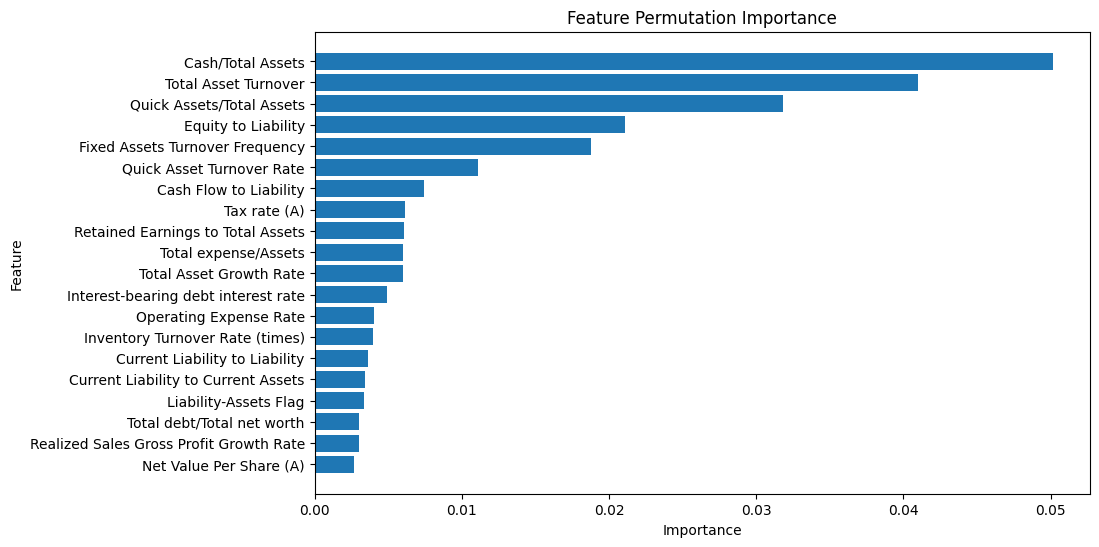

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Cash/Total Assets', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Cash/Total Assets', 'Total Asset Turnover', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Cash/Total Assets', 'Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Cash/Total Assets', 'Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability', 'Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Cash/Total Assets', 'Total Asset Turnover',

In [ ]:
svm2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   37  1136  184   7      16.74   84.09        86.06     86.00     27.92   
1   37  1141  179   7      17.13   84.09        86.44     86.36     28.46   
2   36  1135  185   8      16.29   81.82        85.98     85.85     27.17   
3   38  1128  192   6      16.52   86.36        85.45     85.48     27.74   
4   35  1127  193   9      15.35   79.55        85.38     85.19     25.74   
5   33  1159  161  11      17.01   75.00        87.80     87.39     27.73   
6   32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
7   32  1185  135  12      19.16   72.73        89.77     89.22     30.33   
8   31  1191  129  13      19.38   70.45        90.23     89.59     30.39   
9   23  1232   88  21      20.72   52.27        93.33     92.01     29.68   
10  20  1245   75  24      21.05   45.45        94.32     92.74     28.78   
11  20  1235   85  24      19.05   45.45        93.56     92.01     26.85   
12  21  1234   86  23      19.63   47.73        93.48     92.01     27.81   
13  20  1245   75  24      21.05   45.45        94.32     92.74     28.78   
14  25  1224   96  19      20.66   56.82        92.73     91.57     30.30   
15  27  1220  100  17      21.26   61.36        92.42     91.42     31.58   
16  23  1260   60  21      27.71   52.27        95.45     94.06     36.22   
17  22  1261   59  22      27.16   50.00        95.53     94.06     35.20   
18  22  1262   58  22      27.50   50.00        95.61     94.13     35.48   
19  21  1260   60  23      25.93   47.73        95.45     93.91     33.60   
20  11  1284   36  33      23.40   25.00        97.27     94.94     24.18   

    balanced_accuracy  num_feat_missing  \
0               85.08                 0   
1               85.27                 1   
2               83.90                 2   
3               85.91                 3   
4               82.46                 4   
5               81.40                 5   
6               81.10                 6   
7               81.25                 7   
8               80.34                 8   
9               72.80                 9   
10              69.89                10   
11              69.51                11   
12              70.61                12   
13              69.89                13   
14              74.77                14   
15              76.89                15   
16              73.86                16   
17              72.77                17   
18              72.80                18   
19              71.59                19   
20              61.14                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2   ['Cash/Total Assets', 'Total Asset Turnover'] ...  
3   ['Cash/Total Assets', 'Total Asset Turnover', ...  
4   ['Cash/Total Assets', 'Total Asset Turnover', ...  
5   ['Cash/Total Assets', 'Total Asset Turnover', ...  
6   ['Cash/Total Assets', 'Total Asset Turnover', ...  
7   ['Cash/Total Assets', 'Total Asset Turnover', ...  
8   ['Cash/Total Assets', 'Total Asset Turnover', ...  
9   ['Cash/Total Assets', 'Total Asset Turnover', ...  
10  ['Cash/Total Assets', 'Total Asset Turnover', ...  
11  ['Cash/Total Assets', 'Total Asset Turnover', ...  
12  ['Cash/Total Assets', 'Total Asset Turnover', ...  
13  ['Cash/Total Assets', 'Total Asset Turnover', ...  
14  ['Cash/Total Assets', 'Total Asset Turnover', ...  
15  ['Cash/Total Assets', 'Total Asset Turnover', ...  
16  ['Cash/Total Assets', 'Total Asset Turnover', ...  
17  ['Cash/Total Assets', 'Total Asset Turnover', ...  
18  ['Cash/Total Assets', 'Total Asset Turnover', ...  
19  ['Cash/Total Assets', 'Total Asset Turnover', ...  
20  ['Cash/Total Assets', 'Total Asset Turnover', ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:13:38.926232

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent liabil

In [ ]:
svm2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   37  1136  184   7      16.74   84.09        86.06     86.00     27.92   
1   37  1148  172   7      17.70   84.09        86.97     86.88     29.25   
2   37  1155  165   7      18.32   84.09        87.50     87.39     30.08   
3   37  1157  163   7      18.50   84.09        87.65     87.54     30.33   
4   37  1165  155   7      19.27   84.09        88.26     88.12     31.36   
5   36  1172  148   8      19.57   81.82        88.79     88.56     31.58   
6   37  1139  181   7      16.97   84.09        86.29     86.22     28.24   
7   37  1136  184   7      16.74   84.09        86.06     86.00     27.92   
8   37  1153  167   7      18.14   84.09        87.35     87.24     29.84   
9   37  1165  155   7      19.27   84.09        88.26     88.12     31.36   
10  35  1172  148   9      19.13   79.55        88.79     88.49     30.84   
11  37  1156  164   7      18.41   84.09        87.58     87.46     30.20   
12  38  1160  160   6      19.19   86.36        87.88     87.83     31.40   
13  37  1129  191   7      16.23   84.09        85.53     85.48     27.21   
14  37  1153  167   7      18.14   84.09        87.35     87.24     29.84   
15  38  1154  166   6      18.63   86.36        87.42     87.39     30.65   
16  37  1163  157   7      19.07   84.09        88.11     87.98     31.09   
17  36  1164  156   8      18.75   81.82        88.18     87.98     30.51   
18  36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
19  36  1169  151   8      19.25   81.82        88.56     88.34     31.17   
20  34  1191  129  10      20.86   77.27        90.23     89.81     32.85   

    balanced_accuracy  num_feat_missing  \
0               85.08                 0   
1               85.53                 1   
2               85.80                 2   
3               85.87                 3   
4               86.17                 4   
5               85.30                 5   
6               85.19                 6   
7               85.08                 7   
8               85.72                 8   
9               86.17                 9   
10              84.17                10   
11              85.83                11   
12              87.12                12   
13              84.81                13   
14              85.72                14   
15              86.89                15   
16              86.10                16   
17              85.00                17   
18              85.04                18   
19              85.19                19   
20              83.75                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2   ['Cash/Total Assets', 'Total Asset Turnover'] ...  
3   ['Cash/Total Assets', 'Total Asset Turnover', ...  
4   ['Cash/Total Assets', 'Total Asset Turnover', ...  
5   ['Cash/Total Assets', 'Total Asset Turnover', ...  
6   ['Cash/Total Assets', 'Total Asset Turnover', ...  
7   ['Cash/Total Assets', 'Total Asset Turnover', ...  
8   ['Cash/Total Assets', 'Total Asset Turnover', ...  
9   ['Cash/Total Assets', 'Total Asset Turnover', ...  
10  ['Cash/Total Assets', 'Total Asset Turnover', ...  
11  ['Cash/Total Assets', 'Total Asset Turnover', ...  
12  ['Cash/Total Assets', 'Total Asset Turnover', ...  
13  ['Cash/Total Assets', 'Total Asset Turnover', ...  
14  ['Cash/Total Assets', 'Total Asset Turnover', ...  
15  ['Cash/Total Assets', 'Total Asset Turnover', ...  
16  ['Cash/Total Assets', 'Total Asset Turnover', ...  
17  ['Cash/Total Assets', 'Total Asset Turnover', ...  
18  ['Cash/Total Assets', 'Total Asset Turnover', ...  
19  ['Cash/Total Assets', 'Total Asset Turnover', ...  
20  ['Cash/Total Assets', 'Total Asset Turnover', ...

##**Logistic Regression**

In [ ]:
len(lr_X_test.columns)

62

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [2.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:18:13.641174

Nested Cross-validation Results:
Individual scores: [0.8074923  0.82638127 0.83321128]
Average nested CV score: 0.822 (+/- 0.022)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822
2025-01-16 14:18:48.643825

Execution time: 0.58 minutes




```
Starting hyperparameter tuning at: 2025-01-15 18:00:06.527446

Nested Cross-validation Results:
Individual scores: [0.8074923  0.82638127 0.83179002]
Average nested CV score: 0.822 (+/- 0.021)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822

Train score: 0.879
Test score: 0.822
Train-test score difference: 0.057
2025-01-15 18:02:42.768018

Execution time: 2.60 minutes
```



In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
10                      Equity to Liability    0.072290  0.010652
22                        Cash/Total Assets    0.057801  0.008324
1                      Borrowing dependency    0.038426  0.006290
7       Operating Profit Per Share (Yuan ¥)    0.030548  0.010271
32                     Total Asset Turnover    0.019413  0.003423
23                     Total expense/Assets    0.017387  0.003151
31                   Cash Flow to Liability    0.015417  0.003916
2         Retained Earnings to Total Assets    0.014242  0.005721
33                Quick Assets/Total Assets    0.013998  0.005050
27                      Cash Flow to Equity    0.008959  0.001256
50          Inventory Turnover Rate (times)    0.006819  0.001816
44                       Cash Turnover Rate    0.006667  0.002952
48           Current Liability to Liability    0.006573  0.000690
12                    Liability-Assets Flag    0.006174  0.000071
47      Interest-bearing debt interest rate    0.006023  0.003928
5                   Net Value Per Share (A)    0.005927  0.005631
36                  Total Asset Growth Rate    0.004546  0.001164
49                Quick Asset Turnover Rate    0.003352  0.001433
45               Total debt/Total net worth    0.003163  0.000076
39  Realized Sales Gross Profit Growth Rate    0.003030  0.000300
17                   Operating Gross Margin    0.002689  0.001990
55             Accounts Receivable Turnover    0.002140  0.001403
4       Current Liability to Current Assets    0.001894  0.001708
13                             Tax rate (A)    0.001761  0.001458
51                Total assets to GNP price    0.001591  0.001304
0        Net Income to Stockholder's Equity    0.001307  0.001420
59                   Operating Expense Rate    0.000473  0.002111
18                           Cash flow rate    0.000417  0.001496
26                   Cash/Current Liability    0.000208  0.000110
14                   Interest Expense Ratio    0.000095  0.000060
34                   Fixed Assets to Assets    0.000019  0.000038
43                              Quick Ratio    0.000019  0.000038
57              Inventory/Current Liability    0.000019  0.000071
56                  Average Collection Days    0.000019  0.000110
24         After-tax Net Profit Growth Rate    0.000019  0.000126
53    Long-term Liability to Current Assets   -0.000152  0.000076
30       Degree of Financial Leverage (DFL)   -0.000322  0.000128
11              Operating profit per person   -0.000398  0.001089
9             Equity to Long-term Liability   -0.001099  0.001033
46    Research and development expense rate   -0.001136  0.001355
54              Current Asset Turnover Rate   -0.002576  0.002165
38          Fixed Assets Turnover Frequency   -0.004830  0.001919

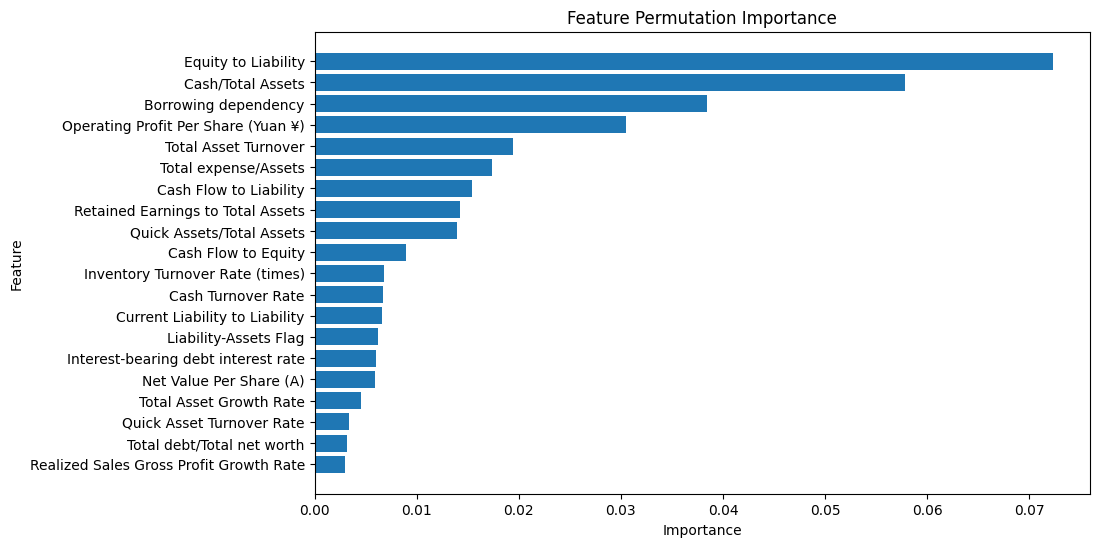

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Operating Profit Per Share (Yuan ¥)
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'Borrowing dependency', 'Operating Profit Per Share (Yuan ¥)']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'Borrowing dependency', 'Operating Profit Per Share (Yuan ¥)', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'B

In [ ]:
lr2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1128  192   8      15.79   81.82        85.45     85.34     26.47   
1   34  1143  177  10      16.11   77.27        86.59     86.29     26.67   
2   33  1146  174  11      15.94   75.00        86.82     86.44     26.29   
3   15  1278   42  29      26.32   34.09        96.82     94.79     29.70   
4    9  1290   30  35      23.08   20.45        97.73     95.23     21.69   
5    8  1291   29  36      21.62   18.18        97.80     95.23     19.75   
6    2  1303   17  42      10.53    4.55        98.71     95.67      6.35   
7    2  1308   12  42      14.29    4.55        99.09     96.04      6.90   
8    2  1312    8  42      20.00    4.55        99.39     96.33      7.41   
9    2  1313    7  42      22.22    4.55        99.47     96.41      7.55   
10   2  1317    3  42      40.00    4.55        99.77     96.70      8.16   
11   2  1317    3  42      40.00    4.55        99.77     96.70      8.16   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               83.64                 0   
1               81.93                 1   
2               80.91                 2   
3               65.45                 3   
4               59.09                 4   
5               57.99                 5   
6               51.63                 6   
7               51.82                 7   
8               51.97                 8   
9               52.01                 9   
10              52.16                10   
11              52.16                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash/Total Assets'] i...  
3   ['Equity to Liability', 'Cash/Total Assets', '...  
4   ['Equity to Liability', 'Cash/Total Assets', '...  
5   ['Equity to Liability', 'Cash/Total Assets', '...  
6   ['Equity to Liability', 'Cash/Total Assets', '...  
7   ['Equity to Liability', 'Cash/Total Assets', '...  
8   ['Equity to Liability', 'Cash/Total Assets', '...  
9   ['Equity to Liability', 'Cash/Total Assets', '...  
10  ['Equity to Liability', 'Cash/Total Assets', '...  
11  ['Equity to Liability', 'Cash/Total Assets', '...  
12  ['Equity to Liability', 'Cash/Total Assets', '...  
13  ['Equity to Liability', 'Cash/Total Assets', '...  
14  ['Equity to Liability', 'Cash/Total Assets', '...  
15  ['Equity to Liability', 'Cash/Total Assets', '...  
16  ['Equity to Liability', 'Cash/Total Assets', '...  
17  ['Equity to Liability', 'Cash/Total Assets', '...  
18  ['Equity to Liability', 'Cash/Total Assets', '...  
19  ['Equity to Liability', 'Cash/Total Assets', '...  
20  ['Equity to Liability', 'Cash/Total Assets', '...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:19:01.940537

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent liab

In [ ]:
lr2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1128  192   8      15.79   81.82        85.45     85.34     26.47   
1   35  1141  179   9      16.36   79.55        86.44     86.22     27.13   
2   35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
3   34  1180  140  10      19.54   77.27        89.39     89.00     31.19   
4   33  1184  136  11      19.53   75.00        89.70     89.22     30.99   
5   35  1189  131   9      21.08   79.55        90.08     89.74     33.33   
6   34  1188  132  10      20.48   77.27        90.00     89.59     32.38   
7   34  1183  137  10      19.88   77.27        89.62     89.22     31.63   
8   33  1193  127  11      20.62   75.00        90.38     89.88     32.35   
9   34  1196  124  10      21.52   77.27        90.61     90.18     33.66   
10  34  1204  116  10      22.67   77.27        91.21     90.76     35.05   
11  32  1209  111  12      22.38   72.73        91.59     90.98     34.22   
12  33  1197  123  11      21.15   75.00        90.68     90.18     33.00   
13  32  1198  122  12      20.78   72.73        90.76     90.18     32.32   
14  31  1199  121  13      20.39   70.45        90.83     90.18     31.63   
15  32  1202  118  12      21.33   72.73        91.06     90.47     32.99   
16  28  1220  100  16      21.88   63.64        92.42     91.50     32.56   
17  29  1217  103  15      21.97   65.91        92.20     91.35     32.95   
18  31  1213  107  13      22.46   70.45        91.89     91.20     34.07   
19  31  1214  106  13      22.63   70.45        91.97     91.28     34.25   
20  30  1218  102  14      22.73   68.18        92.27     91.50     34.09   

    balanced_accuracy  num_feat_missing  \
0               83.64                 0   
1               82.99                 1   
2               83.64                 2   
3               83.33                 3   
4               82.35                 4   
5               84.81                 5   
6               83.64                 6   
7               83.45                 7   
8               82.69                 8   
9               83.94                 9   
10              84.24                10   
11              82.16                11   
12              82.84                12   
13              81.74                13   
14              80.64                14   
15              81.89                15   
16              78.03                16   
17              79.05                17   
18              81.17                18   
19              81.21                19   
20              80.23                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash/Total Assets'] i...  
3   ['Equity to Liability', 'Cash/Total Assets', '...  
4   ['Equity to Liability', 'Cash/Total Assets', '...  
5   ['Equity to Liability', 'Cash/Total Assets', '...  
6   ['Equity to Liability', 'Cash/Total Assets', '...  
7   ['Equity to Liability', 'Cash/Total Assets', '...  
8   ['Equity to Liability', 'Cash/Total Assets', '...  
9   ['Equity to Liability', 'Cash/Total Assets', '...  
10  ['Equity to Liability', 'Cash/Total Assets', '...  
11  ['Equity to Liability', 'Cash/Total Assets', '...  
12  ['Equity to Liability', 'Cash/Total Assets', '...  
13  ['Equity to Liability', 'Cash/Total Assets', '...  
14  ['Equity to Liability', 'Cash/Total Assets', '...  
15  ['Equity to Liability', 'Cash/Total Assets', '...  
16  ['Equity to Liability', 'Cash/Total Assets', '...  
17  ['Equity to Liability', 'Cash/Total Assets', '...  
18  ['Equity to Liability', 'Cash/Total Assets', '...  
19  ['Equity to Liability', 'Cash/Total Assets', '...  
20  ['Equity to Liability', 'Cash/Total Assets', '...

# **Results comparison**

##**F1-score**

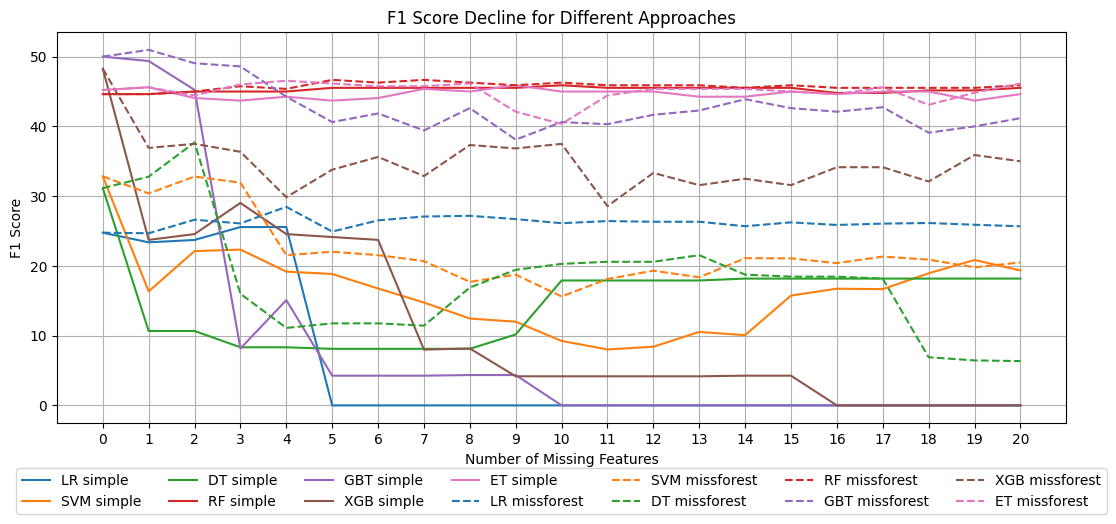

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

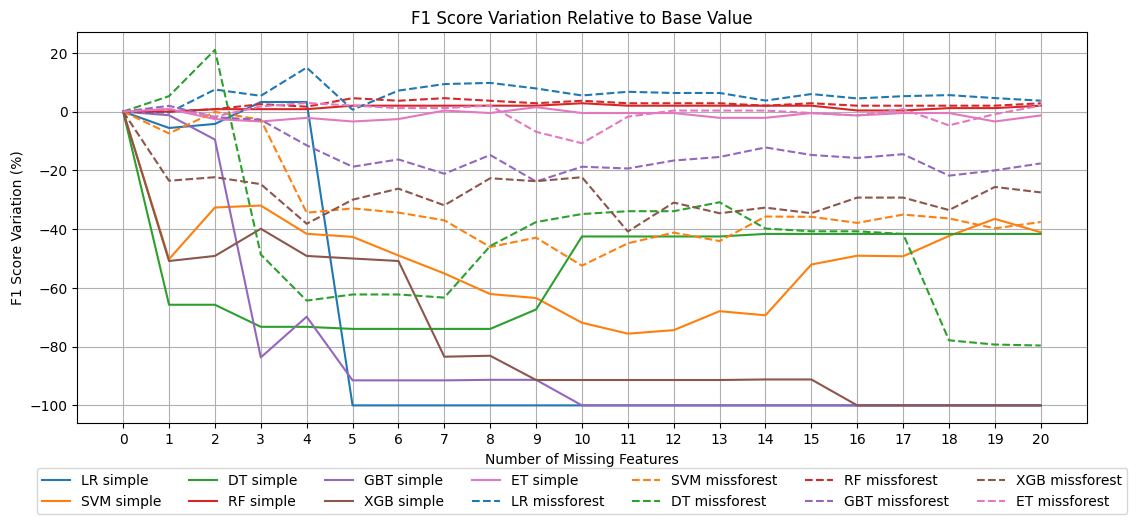

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced Accuracy**

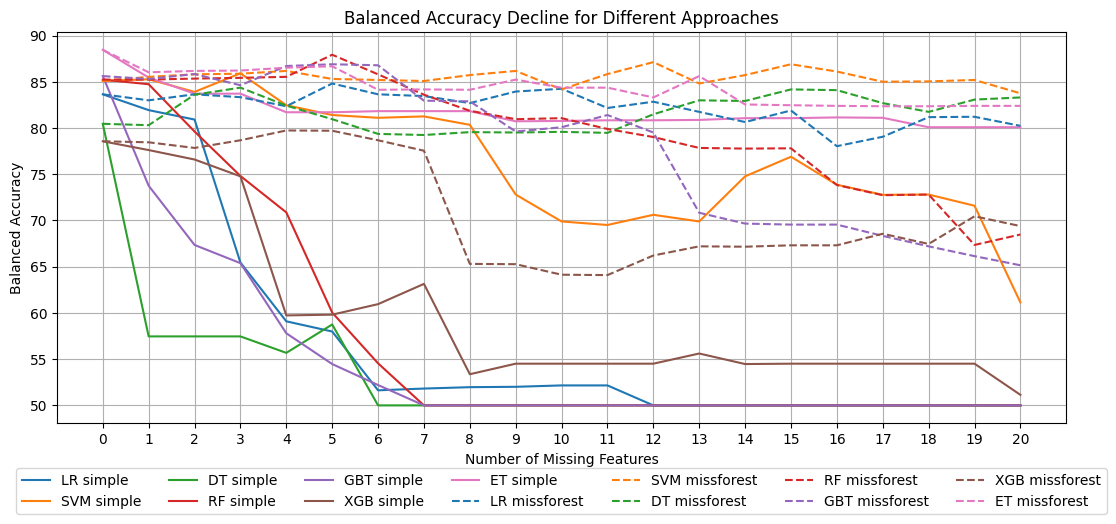

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

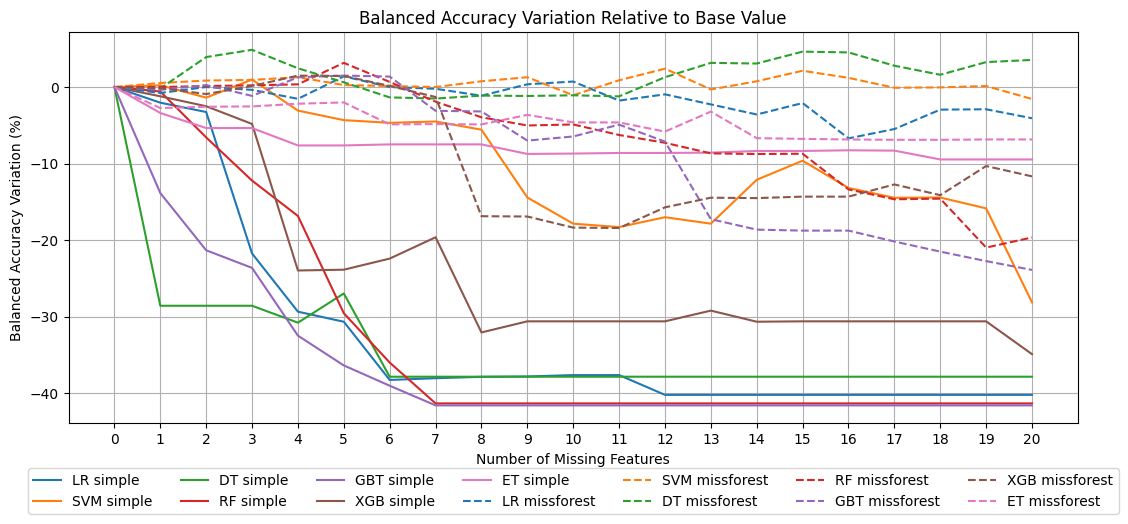

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict,
    'Taiwanese Bankruptcy', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data, 'taiwanese_bankruptcy_scenario2_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    38  1095  225   6      14.45   86.36        82.95     83.06     24.76   
1    38  1077  243   6      13.52   86.36        81.59     81.74     23.38   
2    37  1089  231   7      13.81   84.09        82.50     82.55     23.72   
3    39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
4    39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
..   ..   ...  ...  ..        ...     ...          ...       ...       ...   
583  32  1215  105  12      23.36   72.73        92.05     91.42     35.36   
584  32  1214  106  12      23.19   72.73        91.97     91.35     35.16   
585  32  1214  106  12      23.19   72.73        91.97     91.35     35.16   
586  32  1215  105  12      23.36   72.73        92.05     91.42     35.36   
587  32  1215  105  12      23.36   72.73        92.05     91.42     35.36   

     balanced_accuracy  num_feat_missing  \
0                84.66                 0   
1                83.98                 1   
2                83.30                 2   
3                85.91                 3   
4                85.91                 4   
..                 ...               ...   
583              82.39                16   
584              82.35                17   
585              82.35                18   
586              82.39                19   
587              82.39                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                ['Quick Assets/Total Assets'] imputed      lr_perf   
2    ['Quick Assets/Total Assets', 'Cash/Total Asse...      lr_perf   
3    ['Quick Assets/Total Assets', 'Cash/Total Asse...      lr_perf   
4    ['Quick Assets/Total Assets', 'Cash/Total Asse...      lr_perf   
..                                                 ...          ...   
583  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
584  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
585  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
586  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
587  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   

                   source                          scenario  random_state  \
0    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
1    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
2    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
3    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
4    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
..                    ...                               ...           ...   
583  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
584  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
585  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
586  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   
587  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2024   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]